# Bibliotecas

In [1]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from config import settings
from scripts.AutoClusterHPO import AutoClusterHPO
from scripts.PCATransformer import PCATransformer
from scripts.DataFrameFeatureSelector import DataFrameFeatureSelector 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f, pearsonr, chi2_contingency, f
from scipy.stats.contingency import association
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import math
from sklearn.datasets import make_regression

pd.options.display.float_format = '{:.2f}'.format

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Leitura dos Dados

In [3]:
df_pof_domicilio = pd.read_csv(settings.DADOS_CSV, sep=',')

# AED

In [4]:
cols_numeric = ['Qtd de cômodos', 'Qtd de cômodos dormitórios', 'Qtd de banheiros exclusivos', 
'Qtd de banheiros de uso comum', 'Aluguel Estimado', 'Valor em reais (R$) de despesa realizada',
'Rendimento mensal mínimo geral (R$)', 'Rendimento mensal mínimo p\ alimentação (R$)', 
'Valor em reais (R$) de despesa individual', 'Valor em reais (R$) de despesa coletiva', 
'Valor em reais (R$) do rendimento bruto']

cols_object = ['uf', 'Situação do Domicílio', 'Tipo do domicílio',
 'Material das paredes externas', 'Material do telhado', 'Material do piso',
 'Forma de abastecimento de água', 'Frequência da água proveniente de rede geral',
 'Tipo de chegada da água', 'A água é aquecida por energia elétrica?',
 'A água é aquecida por gás?', 'A água é aquecida por energia solar?',
 'A água é aquecida por lenha ou carvão?', 'A água é aquecida por outra forma?',
 'Utiliza sanitário ou buraco para dejeções?', 'Tipo de escoadouro sanitário',
 'Destino dado ao lixo', 'Energia elétrica é de rede geral?', 'Rede elétrica proveniente de outra origem?',
 'Frequência da energia elétrica de rede geral', 'Utiliza-se gás butijão na preparação de alimentos?',
 'Utiliza-se lenha ou carvão na preparação de alimentos?', 'Utiliza-se energia elétrica na preparação de alimentos?',
 'Utiliza-se outro combustível na preparação de alimentos?', 'Este domicílio é:',
 'Este contrato de aluguel é:', 'A rua onde se localiza é pavimentada?', 'O serviço de correios é realizado:', 
 'Situação de segurança alimentar', 'Aluguel Estimado (Faixa)']

df_pof_domicilio_numeric = df_pof_domicilio[cols_numeric]

df_pof_domicilio_obj = df_pof_domicilio[cols_object]

## Análise Univariada

### Estatísticas

In [13]:
# 1. Obtenha o describe padrão
stats = df_pof_domicilio_numeric.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

# 2. Calcule e adicione as novas estatísticas usando .loc
stats.loc['skew'] = df_pof_domicilio_numeric.skew()
stats.loc['kurtosis'] = df_pof_domicilio_numeric.kurtosis()
stats.loc['mad'] = (df_pof_domicilio_numeric - df_pof_domicilio_numeric.mean()).abs().mean()
stats.loc['cv'] = stats.loc['std'] / stats.loc['mean']
stats.loc['sem'] = df_pof_domicilio_numeric.sem()

stats

Qtd de cômodos  Qtd de cômodos dormitórios  \
count           46315.00                    46315.00   
mean                5.94                        1.87   
std                 1.76                        0.79   
min                 1.00                        1.00   
1%                  2.00                        1.00   
10%                 4.00                        1.00   
25%                 5.00                        1.00   
50%                 6.00                        2.00   
75%                 7.00                        2.00   
90%                 8.00                        3.00   
99%                10.00                        4.00   
max                10.00                        4.00   
skew                0.44                        0.55   
kurtosis            0.07                       -0.35   
mad                 1.36                        0.63   
cv                  0.30                        0.42   
sem                 0.01                        0.00   

          Qtd de banheiros exclusivos  Qtd de banheiros de uso comum  \
count                        46315.00                       46315.00   
mean                             1.31                           0.00   
std                              0.70                           0.00   
min                              0.00                           0.00   
1%                               0.00                           0.00   
10%                              1.00                           0.00   
25%                              1.00                           0.00   
50%                              1.00                           0.00   
75%                              2.00                           0.00   
90%                              2.00                           0.00   
99%                              4.00                           0.00   
max                              4.00                           0.00   
skew                             1.44                           0.00   
kurtosis                         2.86                           0.00   
mad                              0.54                           0.00   
cv                               0.53                            NaN   
sem                              0.00                           0.00   

          Aluguel Estimado  Valor em reais (R$) de despesa realizada  \
count             46315.00                                  46315.00   
mean                532.92                                    106.76   
std                 336.96                                     84.92   
min                   5.00                                      0.87   
1%                   80.00                                      3.07   
10%                 200.00                                     17.92   
25%                 300.00                                     43.05   
50%                 450.00                                     81.06   
75%                 700.00                                    145.54   
90%                1000.00                                    261.23   
99%                1300.00                                    300.00   
max                1300.00                                    300.00   
skew                  0.90                                      1.03   
kurtosis             -0.08                                      0.08   
mad                 270.32                                     67.35   
cv                    0.63                                      0.80   
sem                   1.57                                      0.39   

          Rendimento mensal mínimo geral (R$)  \
count                                46315.00   
mean                                  3135.21   
std                                   1977.08   
min                                     80.00   
1%                                     500.00   
10%                                   1000.00   
25%                                   1600.00   
50%            

### Histogramas

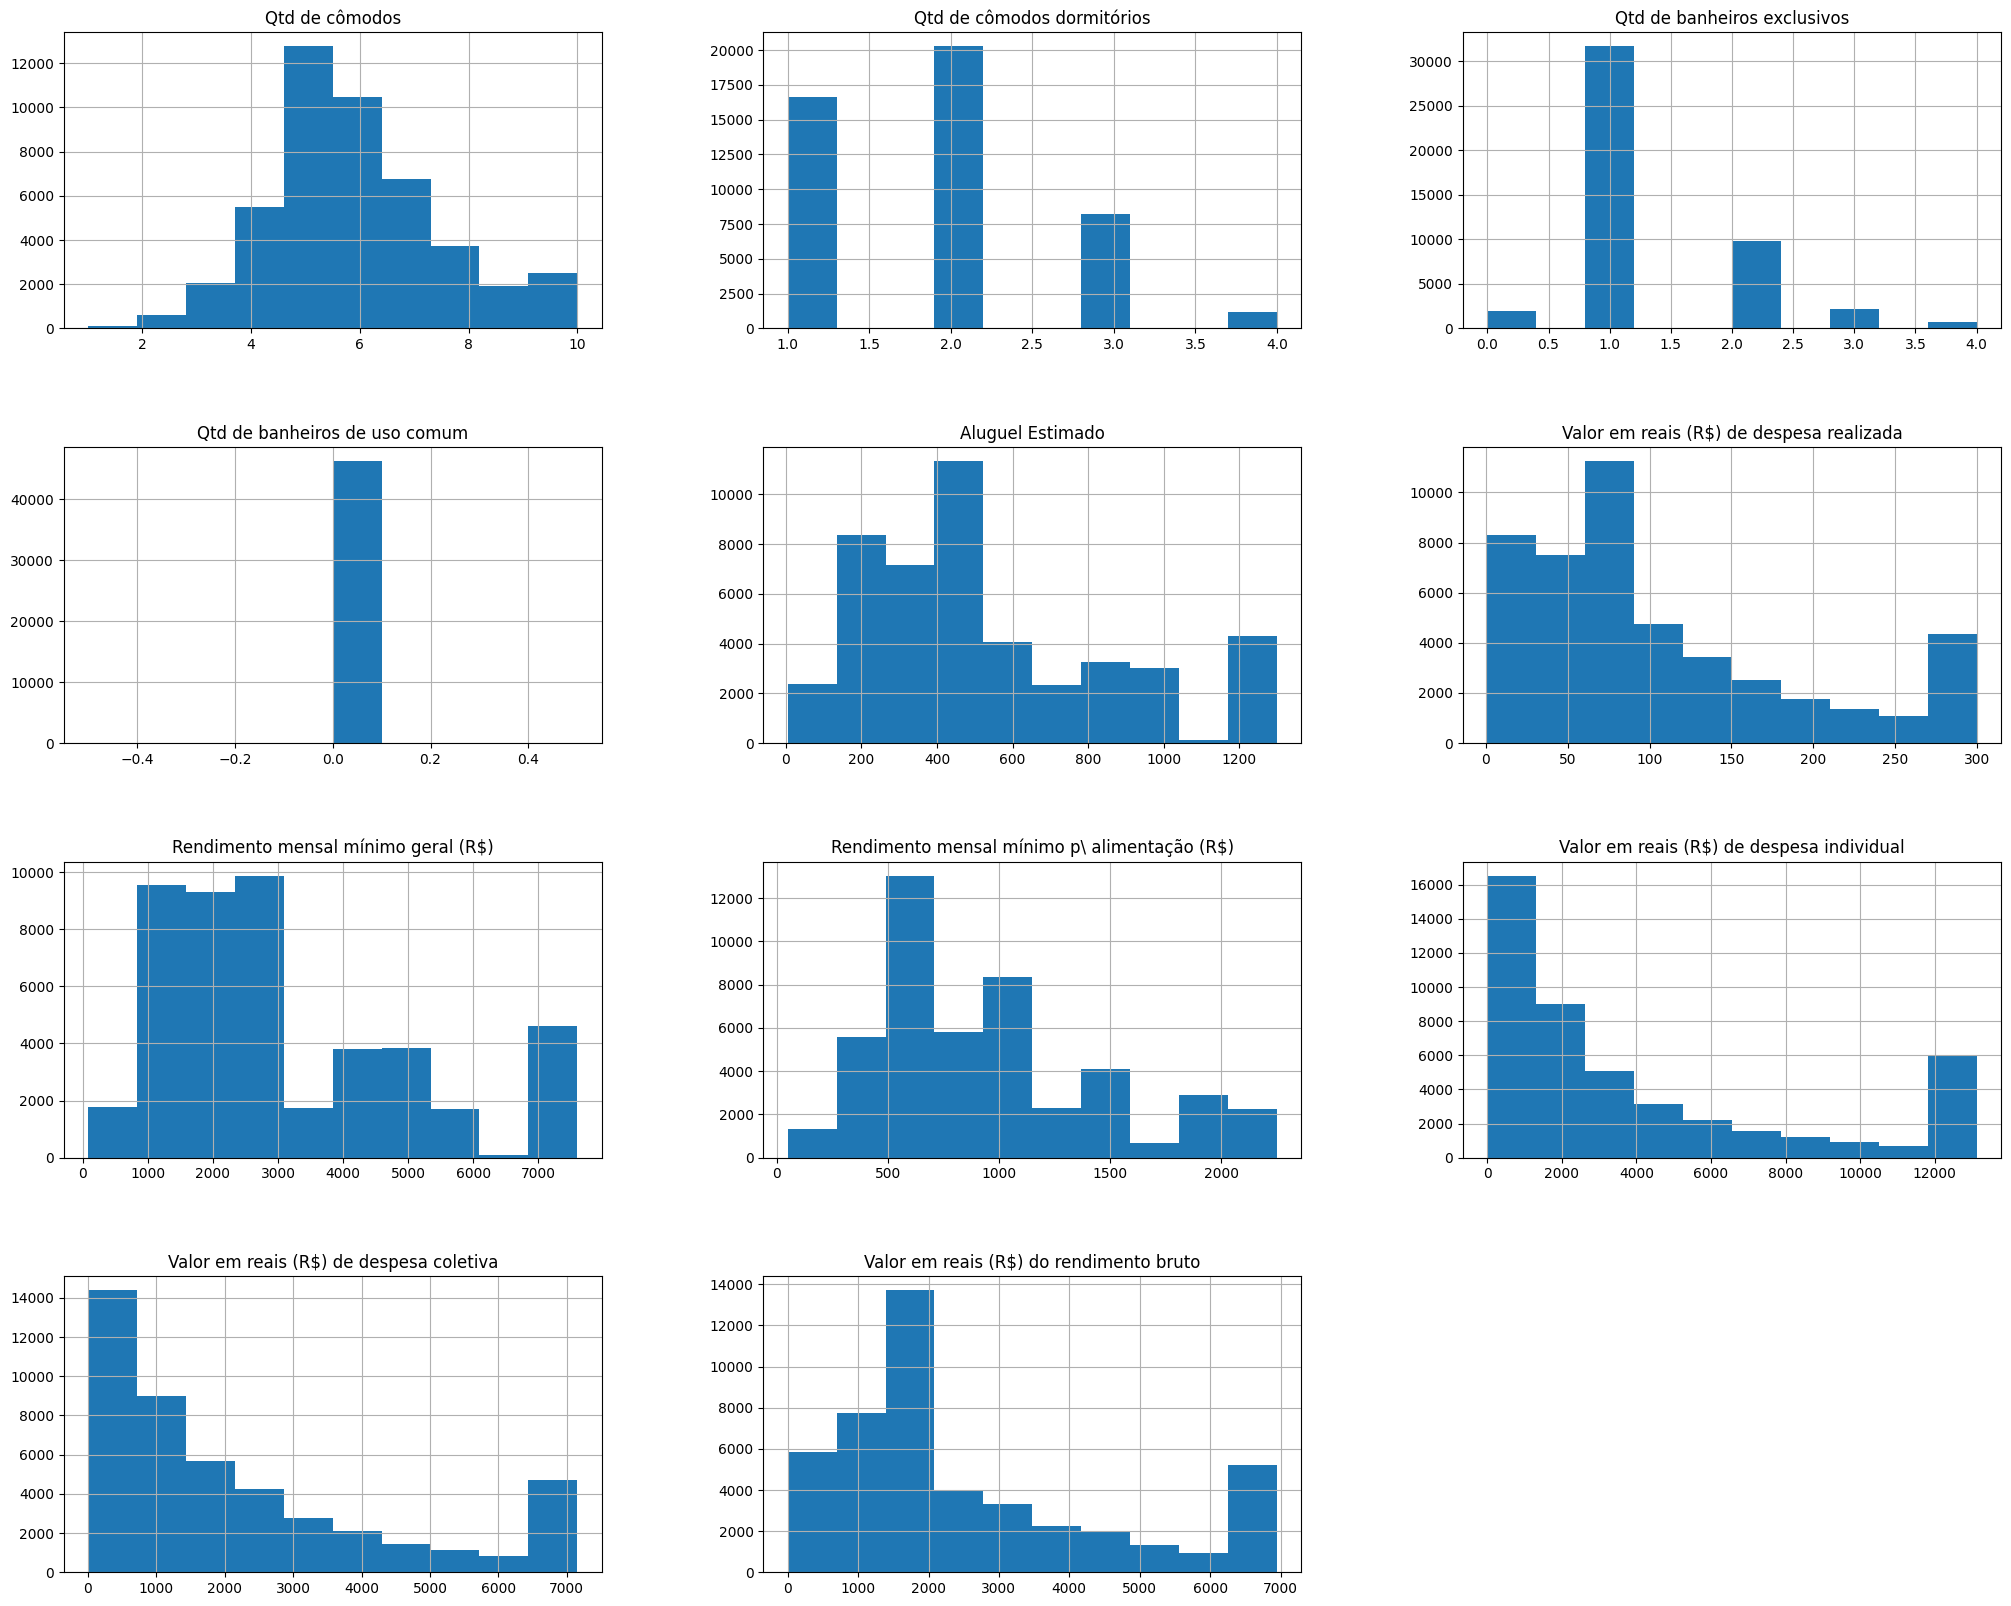

In [ ]:
df_pof_domicilio_numeric.hist(figsize=(25, 20))
plt.subplots_adjust(hspace=0.4)
#plt.savefig('histogramas.png', dpi=300, bbox_inches='tight')
plt.show()

### Pizzas

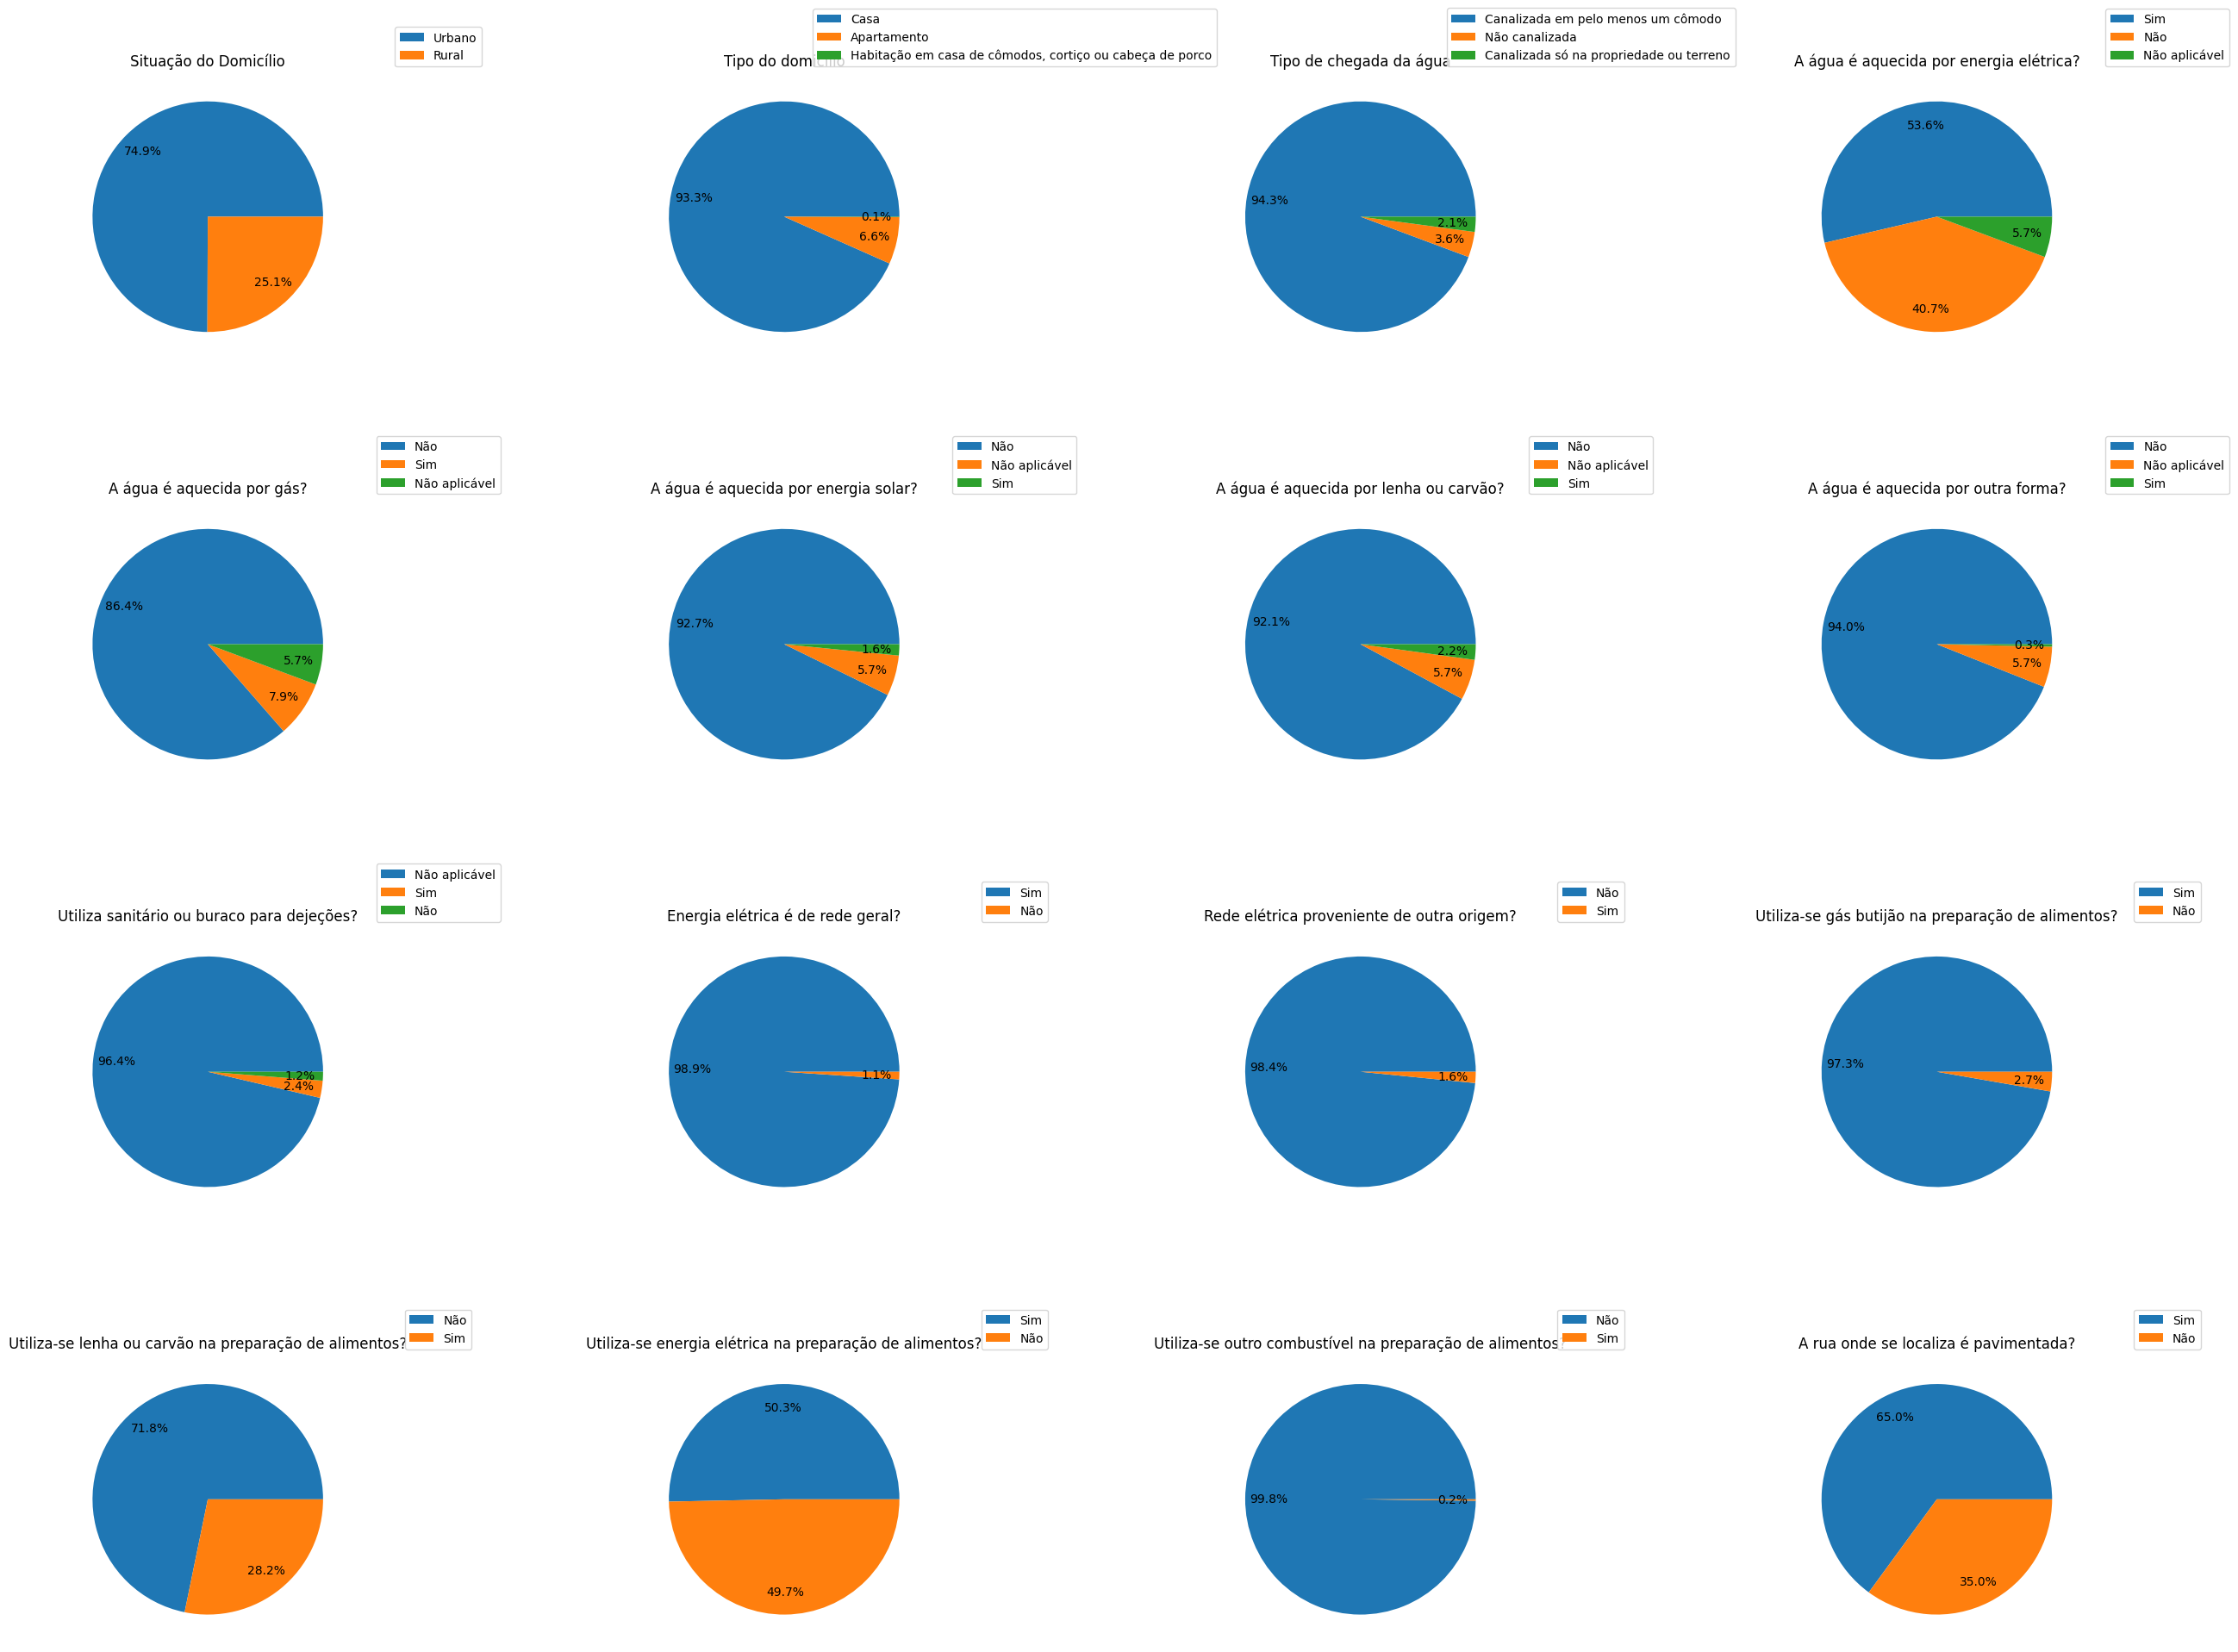

In [14]:
# A sua linha para selecionar as colunas continua a mesma
cols = [col for col in df_pof_domicilio.select_dtypes(include='object').columns if 1 < df_pof_domicilio[col].nunique() < 4]

# ---- INÍCIO DO NOVO CÓDIGO ----

# 1. Definir o tamanho da grade
n_linhas = 4
n_colunas = 4

# 2. Criar a figura e a matriz de eixos (subplots)
# figsize controla o tamanho total da imagem que conterá todos os gráficos
fig, axes = plt.subplots(n_linhas, n_colunas, figsize=(25, 20))

# 3. "Aplainar" a matriz de eixos para facilitar o loop (de 4x4 para 1x16)
axes = axes.flatten()

# 4. Loop para plotar cada gráfico em um eixo
for i, col in enumerate(cols):
    # Se tivermos mais gráficos do que eixos, paramos o loop
    if i >= len(axes):
        print(f"Aviso: Existem mais de {len(axes)} colunas para plotar. Apenas as primeiras {len(axes)} serão exibidas.")
        break
        
    # Seleciona o eixo atual
    ax = axes[i]
    
    # Prepara os dados para o gráfico
    dados_para_plotar = df_pof_domicilio[col].value_counts()
    
    # Plota o gráfico de pizza NO EIXO ESPECÍFICO (usando ax=ax)
    dados_para_plotar.plot(kind='pie', 
                           ax=ax, 
                           autopct='%1.1f%%',
                           pctdistance=0.8, # Distância do texto de % do centro
                           labels=None) # Oculta os rótulos nas fatias para não poluir

    ax.set_title(f'{col}', fontsize=12)
    ax.set_ylabel('') # Remove o texto do eixo Y
    
    # Adiciona uma legenda para identificar as fatias
    ax.legend(labels=dados_para_plotar.index, loc='lower center', bbox_to_anchor=(1.3, 1))


# 5. Ocultar os eixos que não foram usados
# Se você tiver menos de 16 gráficos, os eixos restantes ficarão em branco
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# 6. Ajusta o espaçamento para evitar sobreposição de títulos e gráficos
plt.tight_layout()
plt.subplots_adjust(wspace=1.0)
plt.savefig(r"pizzas.png")
plt.show()

## Análise Bivariada

### Matriz de Correlação

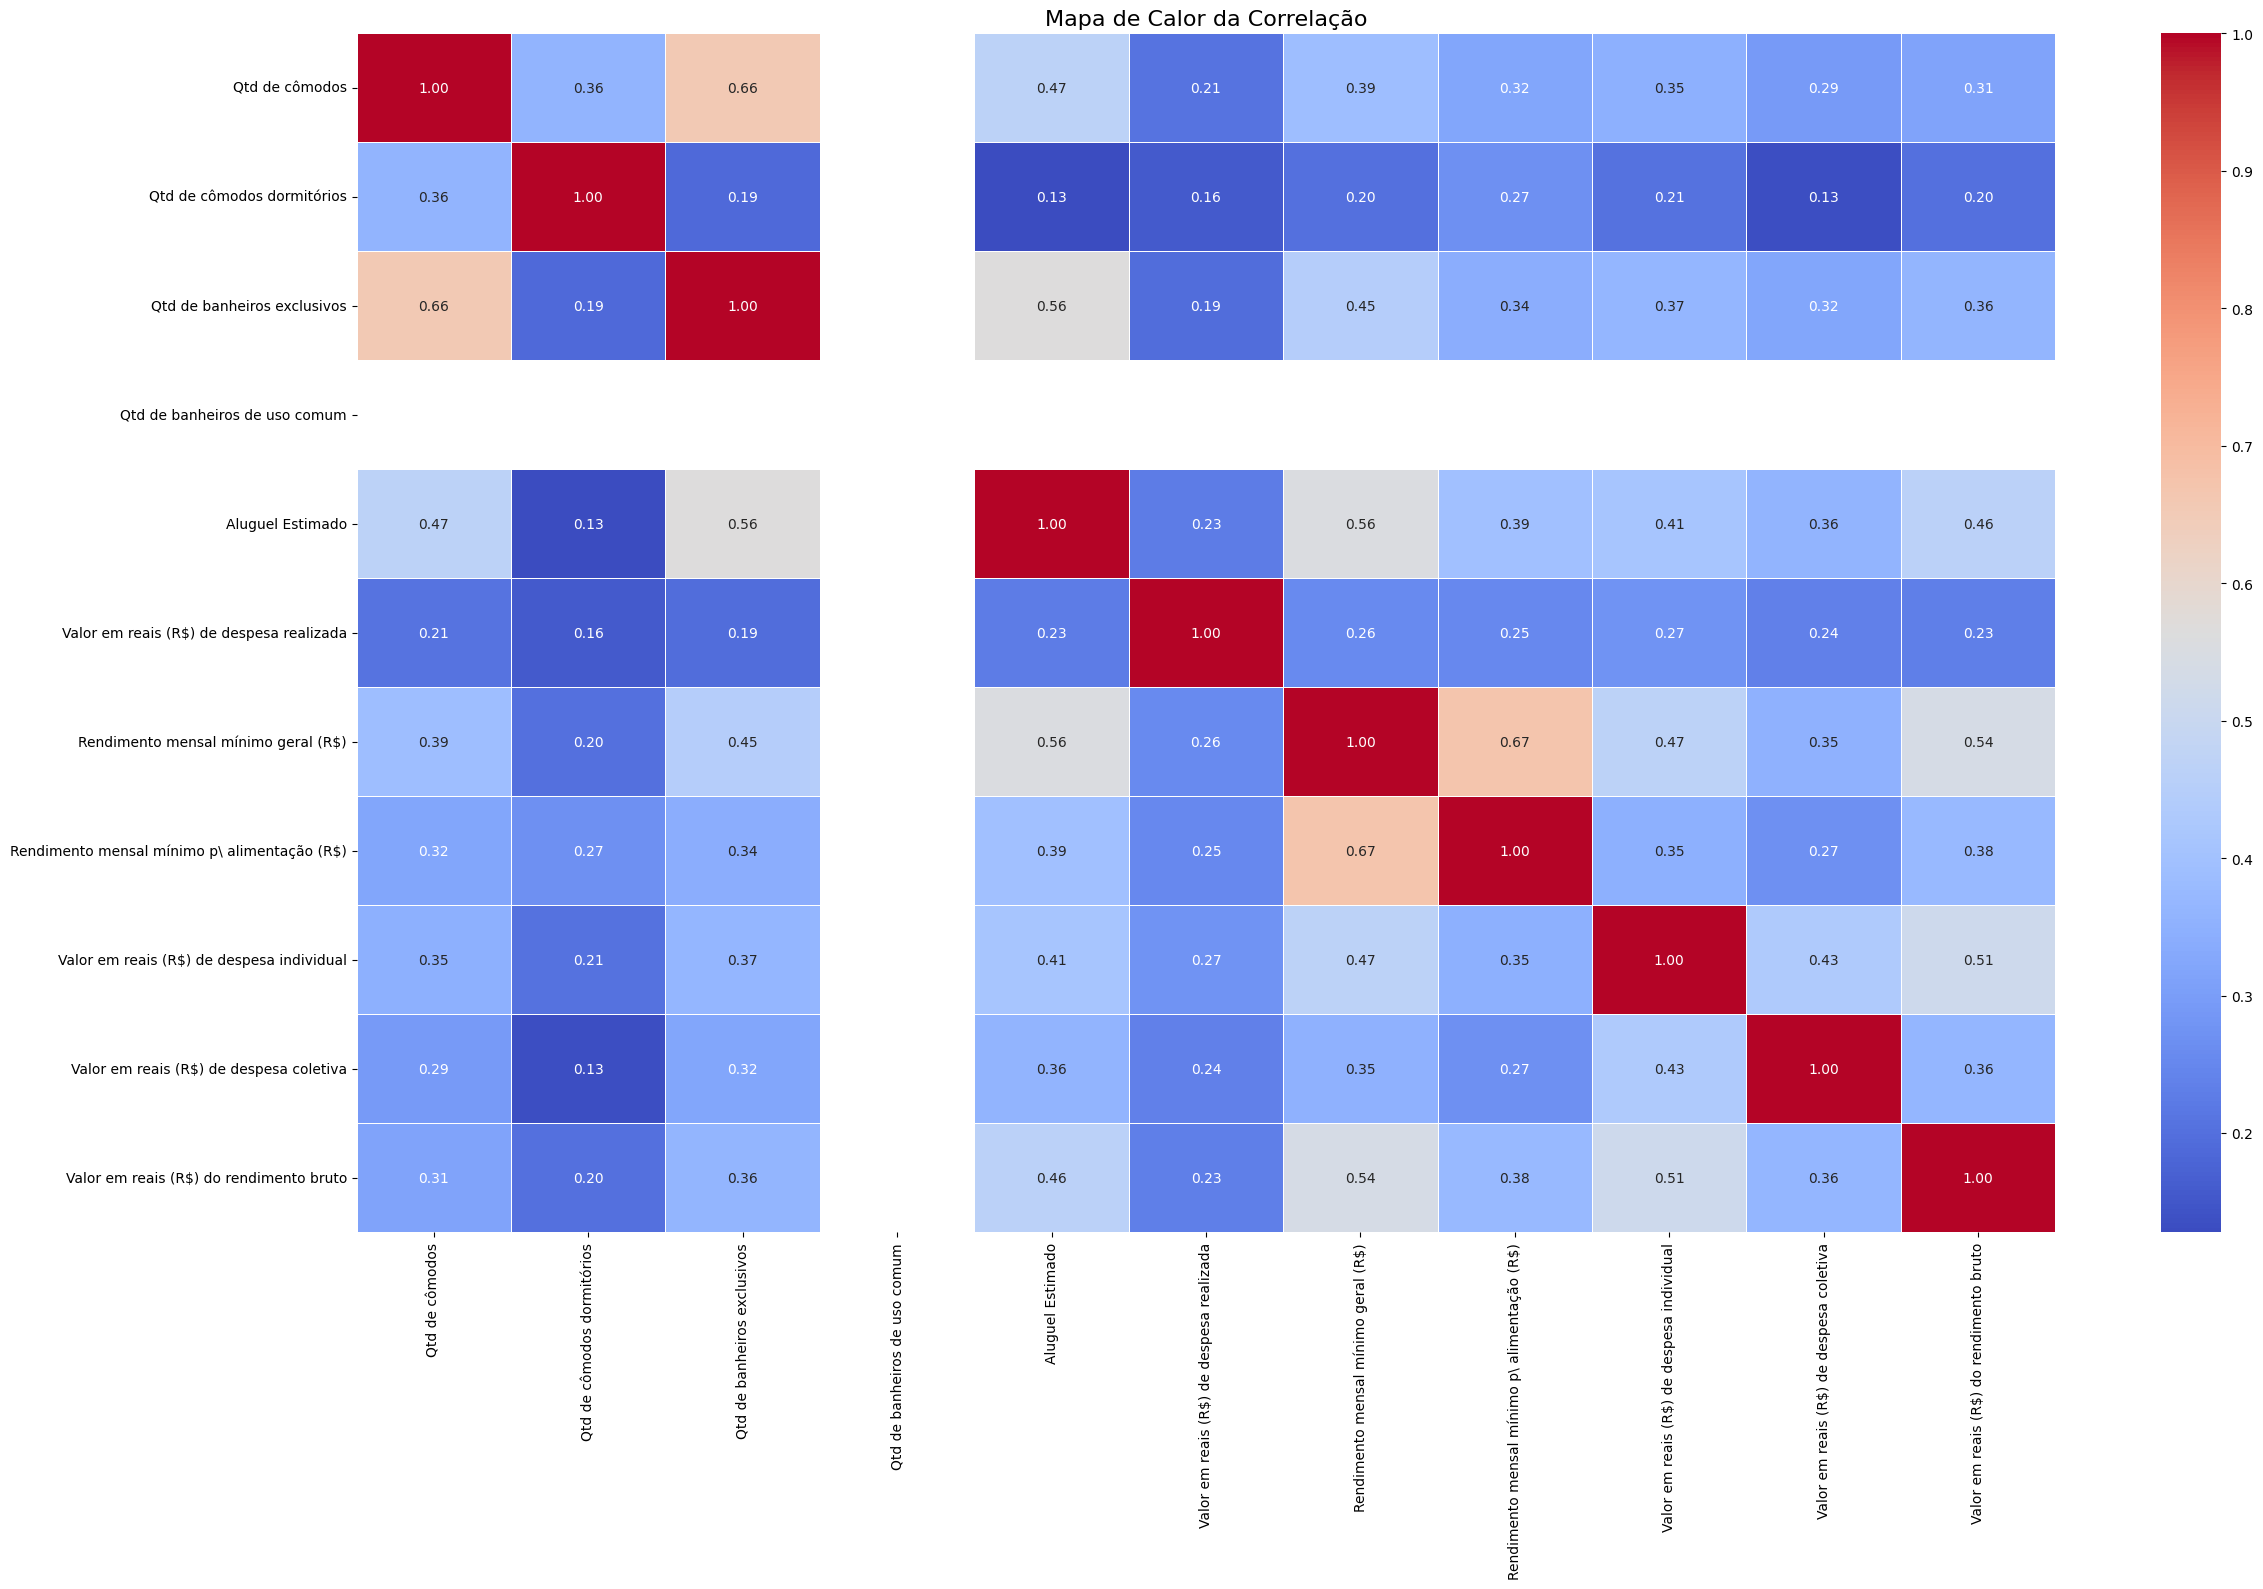

In [15]:
# Calcular a matriz de correlação
corr_matrix = df_pof_domicilio_numeric.corr()

# Configurar a figura do Matplotlib
plt.figure(figsize=(25, 16))

# Gerar o mapa de calor
sns.heatmap(
    corr_matrix, 
    annot=True,      # Mostra os valores de correlação nas células
    fmt='.2f',       # Formata os números para 2 casas decimais
    cmap='coolwarm', # Esquema de cores (divergente é ótimo para correlação)
    linewidths=.5    # Adiciona linhas entre as células
)

plt.title('Mapa de Calor da Correlação', fontsize=16)
plt.tight_layout()
plt.savefig(r"matriz_correlacao.png", dpi=300)
plt.show()

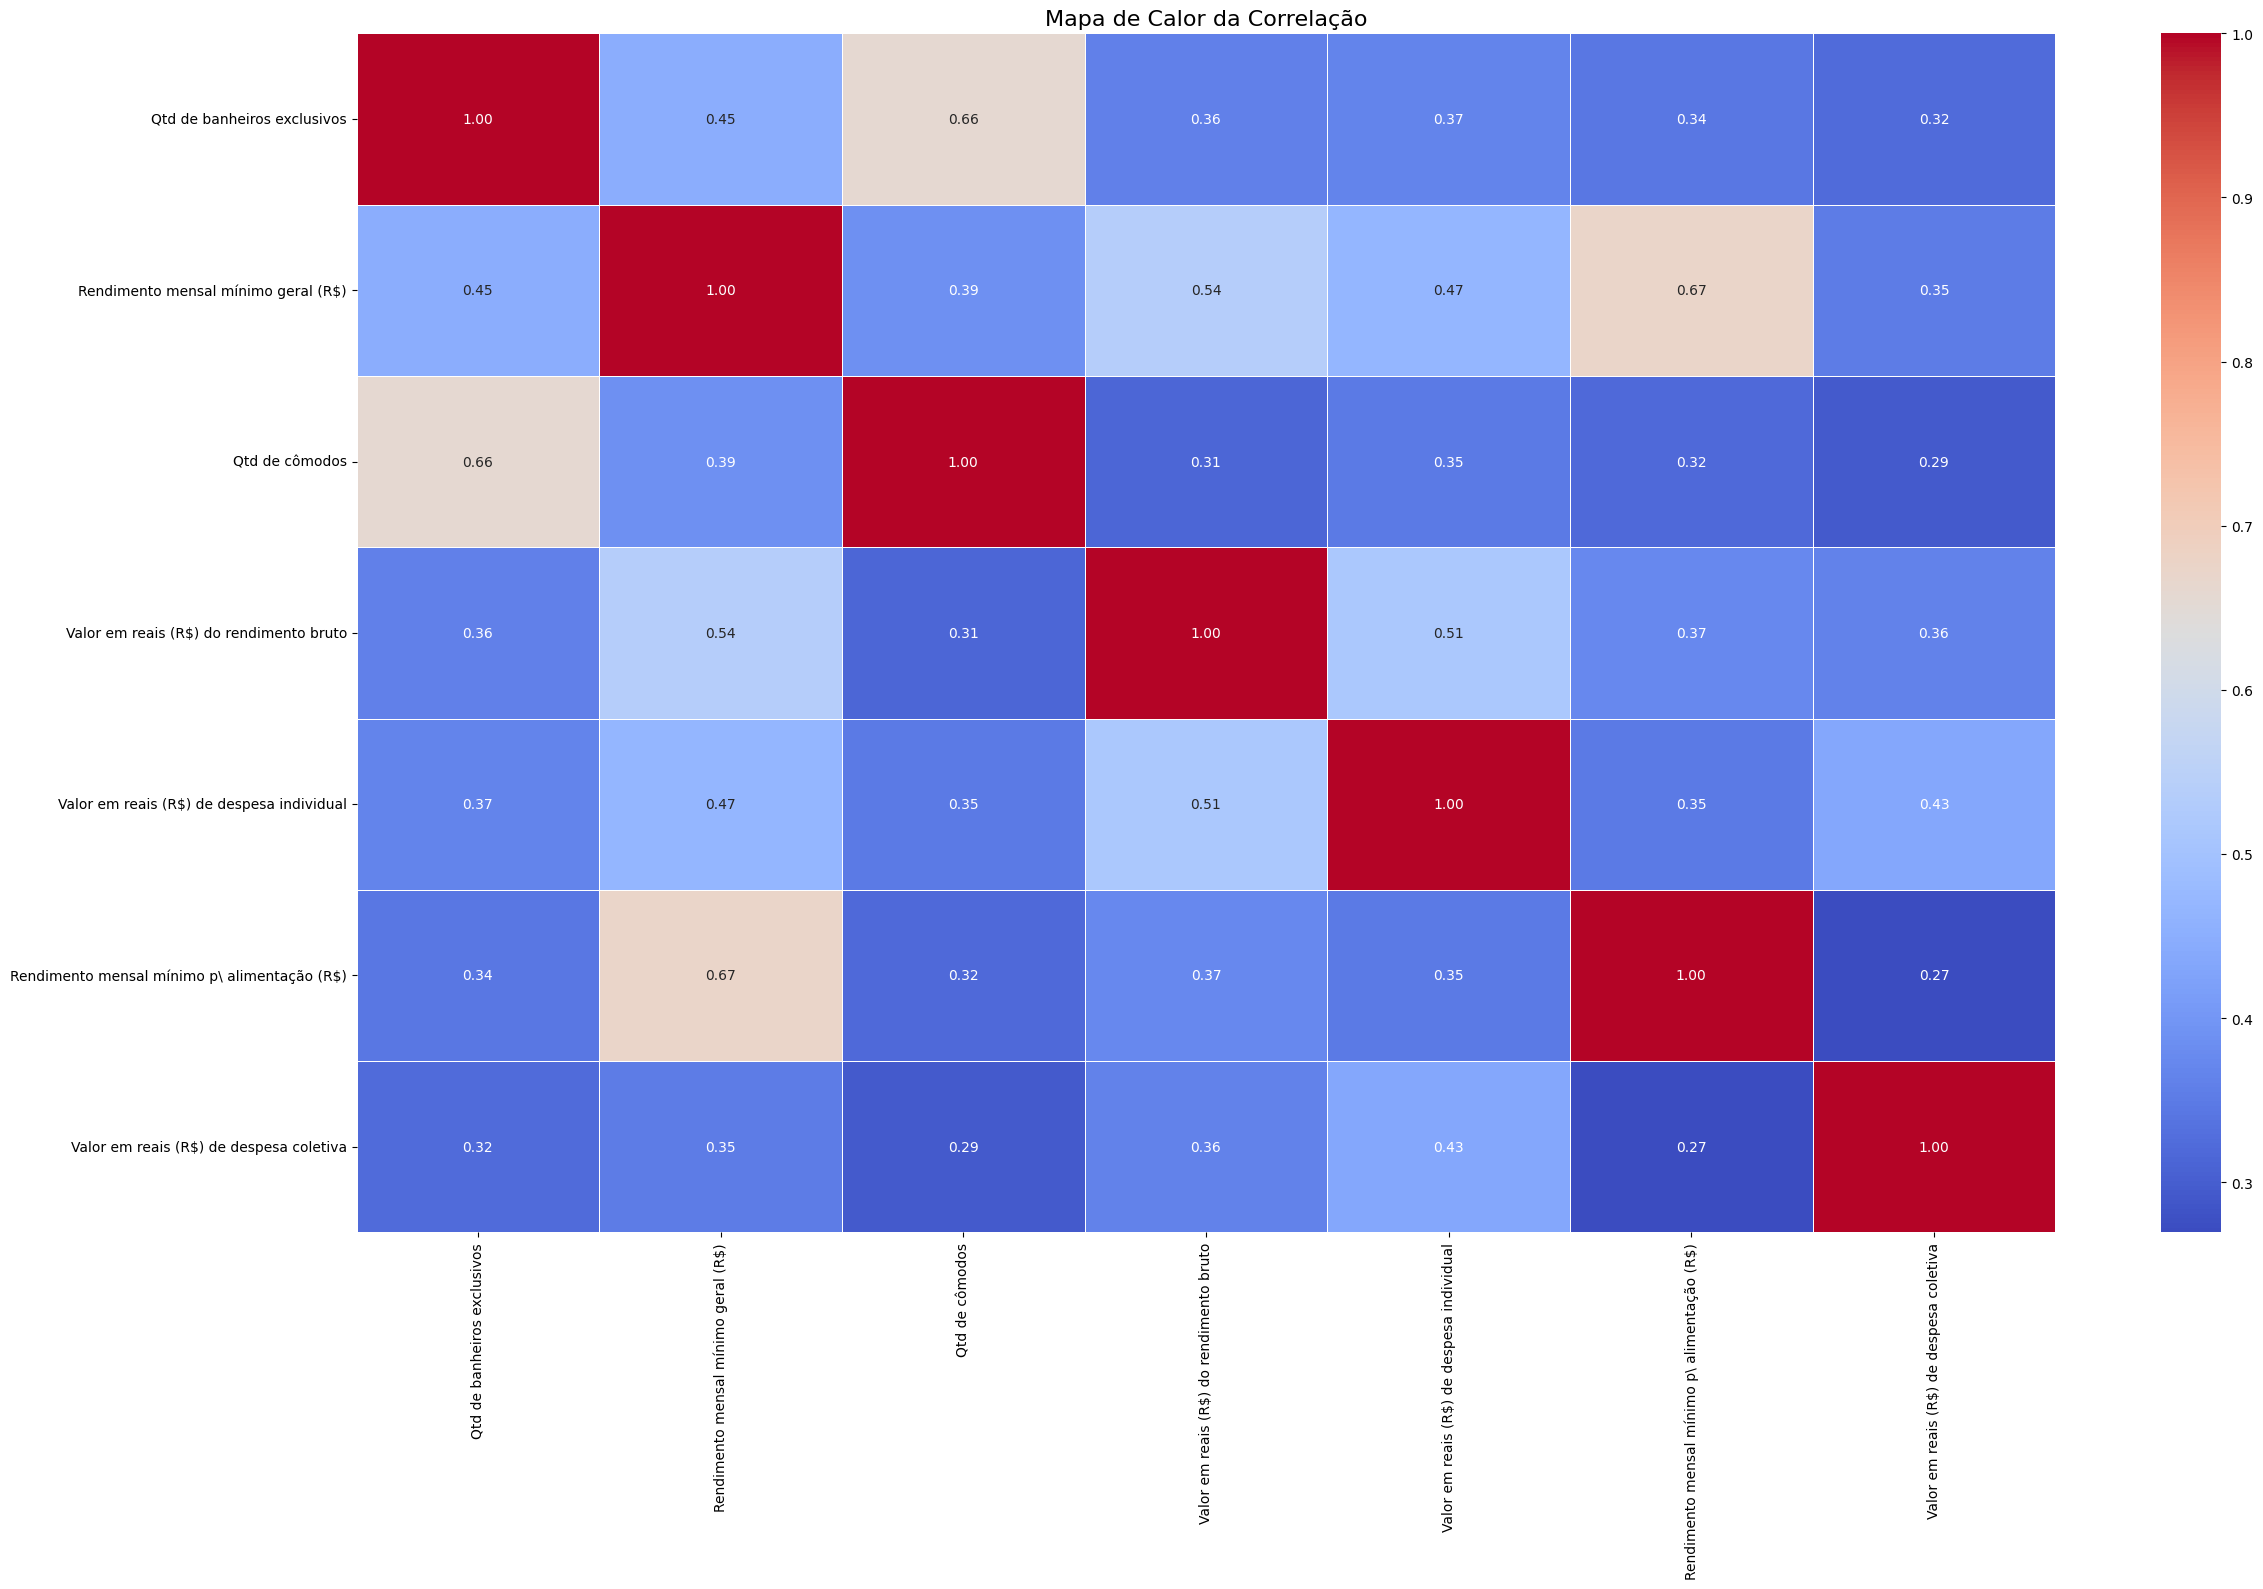

In [25]:
cols = ['Qtd de banheiros exclusivos',
       'Rendimento mensal mínimo geral (R$)', 'Qtd de cômodos',
       'Valor em reais (R$) do rendimento bruto',
       'Valor em reais (R$) de despesa individual',
       'Rendimento mensal mínimo p\\ alimentação (R$)',
       'Valor em reais (R$) de despesa coletiva']

# Calcular a matriz de correlação
corr_matrix = df_pof_domicilio[cols].corr()

# Configurar a figura do Matplotlib
plt.figure(figsize=(25, 16))

# Gerar o mapa de calor
sns.heatmap(
    corr_matrix, 
    annot=True,      # Mostra os valores de correlação nas células
    fmt='.2f',       # Formata os números para 2 casas decimais
    cmap='coolwarm', # Esquema de cores (divergente é ótimo para correlação)
    linewidths=.5    # Adiciona linhas entre as células
)

plt.title('Mapa de Calor da Correlação', fontsize=16)
plt.tight_layout()
plt.savefig(r"Gráficos\Mapa de Calor da Correlação.png", dpi=300)
plt.show()

### Gráficos de Dispersão

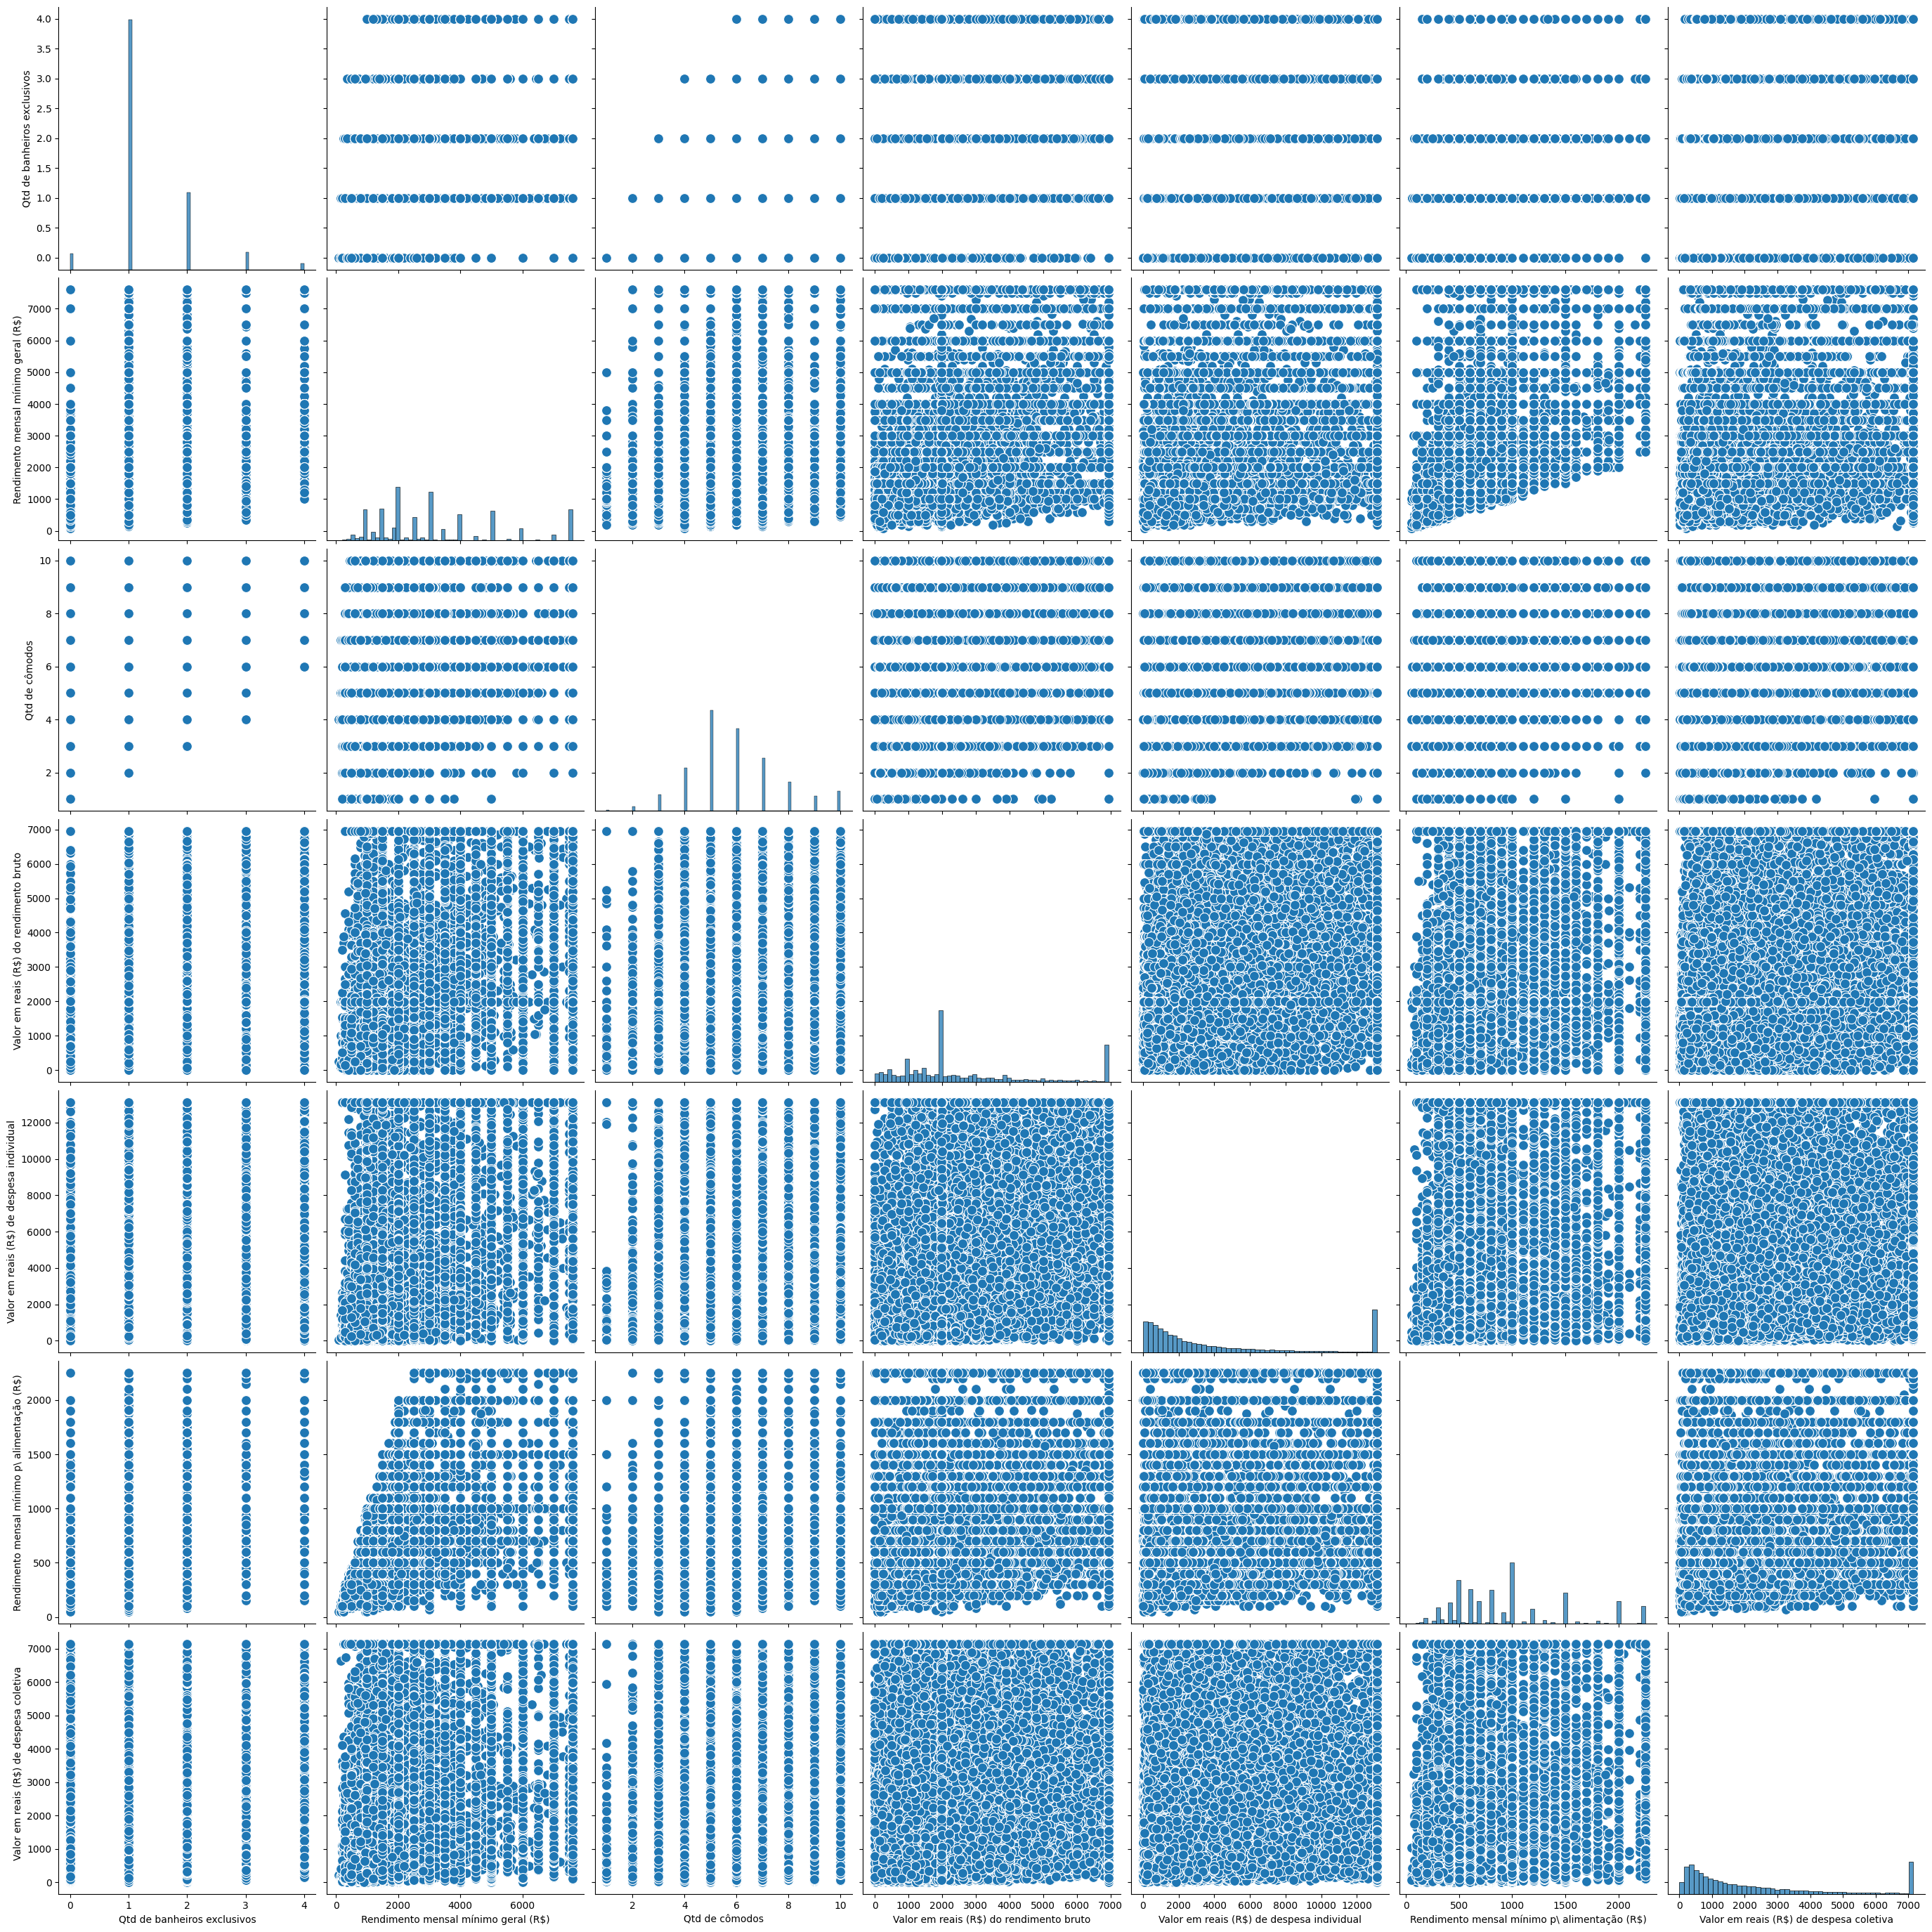

In [ ]:
sns.pairplot(df_pof_domicilio_numeric, 
             height=4,
             plot_kws={
                        's': 100,  # 's' controla o TAMANHO (size) dos pontos. Aumente ou diminua conforme necessário.
                        'alpha': 1.0  # 'alpha' controla a TRANSPARÊNCIA dos pontos, útil quando há sobreposição.
                      })

plt.savefig(r"Gráficos\Gráficos de Dispersão.png", dpi=300)

### Boxplots

<>:53: SyntaxWarning: invalid escape sequence '\B'
<>:53: SyntaxWarning: invalid escape sequence '\B'
C:\Users\user\AppData\Local\Temp\ipykernel_10336\906582919.py:53: SyntaxWarning: invalid escape sequence '\B'
  plt.savefig(f"Gráficos\Boxplots ({'Valor em reais (R$) de despesa realizada'}).png", dpi=300)


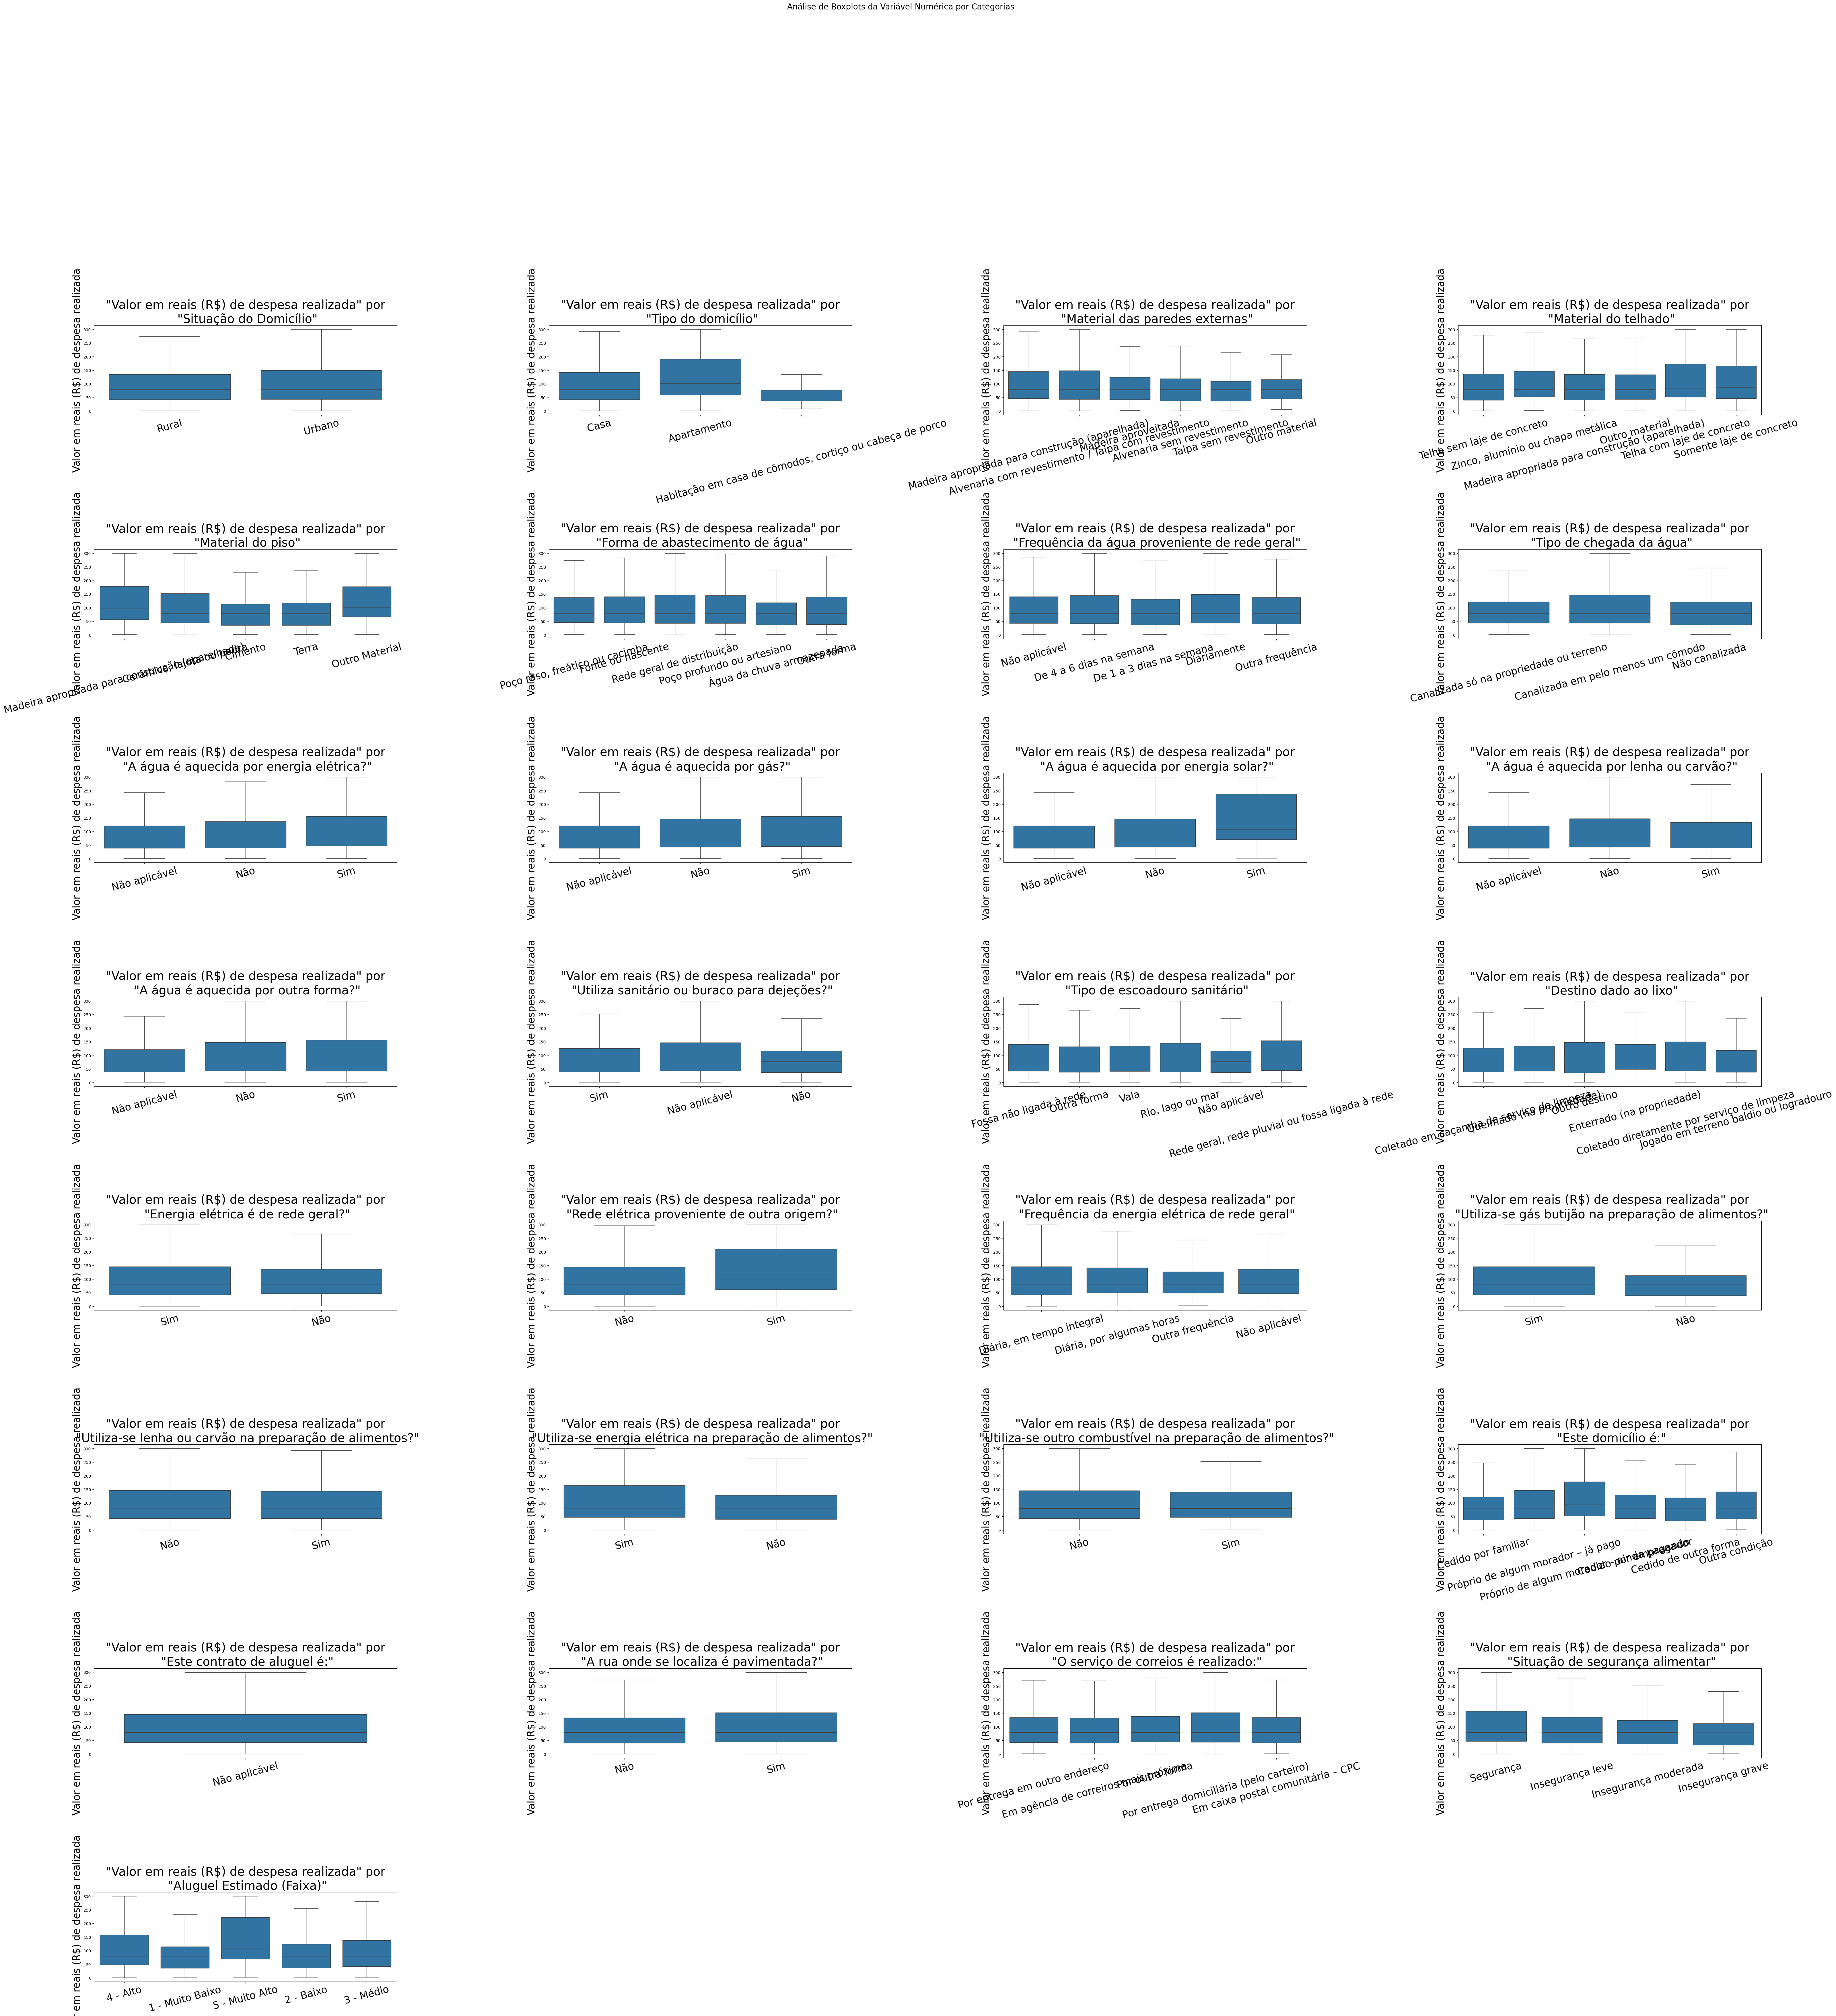

In [27]:
df = df_pof_domicilio

def boxplotsDespesaRealizada(numeric_col):

    try:
        object_cols = df.select_dtypes(include='object').columns[4:]
    except IndexError:
        raise ValueError("DataFrame não contém colunas numéricas ou do tipo 'object' nas quantidades esperadas.")

    # --- Passo 3: Criar a grade de gráficos (subplots) ---

    # Cria a figura e os eixos (axes) com o tamanho calculado
    # O figsize é ajustado dinamicamente para a figura não ficar apertada
    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(75, 75))

    # O 'axes.flatten()' transforma a matriz de eixos 2D em um array 1D para facilitar a iteração
    axes = axes.flatten()

    # --- Passo 4: Loop para criar e plotar cada boxplot ---

    for i, col_cat in enumerate(object_cols):
        ax = axes[i] # Seleciona o eixo atual para desenhar o gráfico
        
        # Cria o boxplot no eixo selecionado
        sns.boxplot(
            x=col_cat,       # Eixo X: as categorias da coluna object atual
            y=numeric_col,   # Eixo Y: a variável numérica
            data=df,         # O DataFrame com os dados
            ax=ax,
            showfliers=False            # O eixo específico onde o gráfico será desenhado
        )
        
        # Personaliza o subplot
        ax.set_title(f'"{numeric_col}" por\n "{col_cat}"', fontsize=30)
        ax.set_xlabel('', fontsize=35) # Remove o label do eixo x para um visual mais limpo
        ax.set_ylabel(f'{numeric_col}', fontsize=25)
        ax.tick_params(axis='x', rotation=15, labelsize=25) # Rotaciona os labels do eixo x se forem longos


    # --- Passo 5: Ajustes Finais ---

    # Oculta os eixos que não foram utilizados (caso o número de plots seja ímpar)
    for i in range(len(object_cols), len(axes)):
        axes[i].set_visible(False)

    # Adiciona um título geral à figura
    fig.suptitle('Análise de Boxplots da Variável Numérica por Categorias', fontsize=20, y=1.03)

    # Ajusta o layout para evitar sobreposição de títulos e labels
    #plt.tight_layout(rect=[0, 0, 1, 0.98]) # rect ajusta o espaço para o suptitle
    plt.subplots_adjust(hspace=1.5, wspace=0.5)

    plt.savefig(f"Gráficos\Boxplots ({'Valor em reais (R$) de despesa realizada'}).png", dpi=300)

    # Mostra a figura final
    plt.show()

boxplotsDespesaRealizada('Valor em reais (R$) de despesa realizada')

<>:53: SyntaxWarning: invalid escape sequence '\B'
<>:53: SyntaxWarning: invalid escape sequence '\B'
C:\Users\user\AppData\Local\Temp\ipykernel_10336\3537979755.py:53: SyntaxWarning: invalid escape sequence '\B'
  plt.savefig(f"Gráficos\Boxplots ({numeric_col}).png", dpi=300)


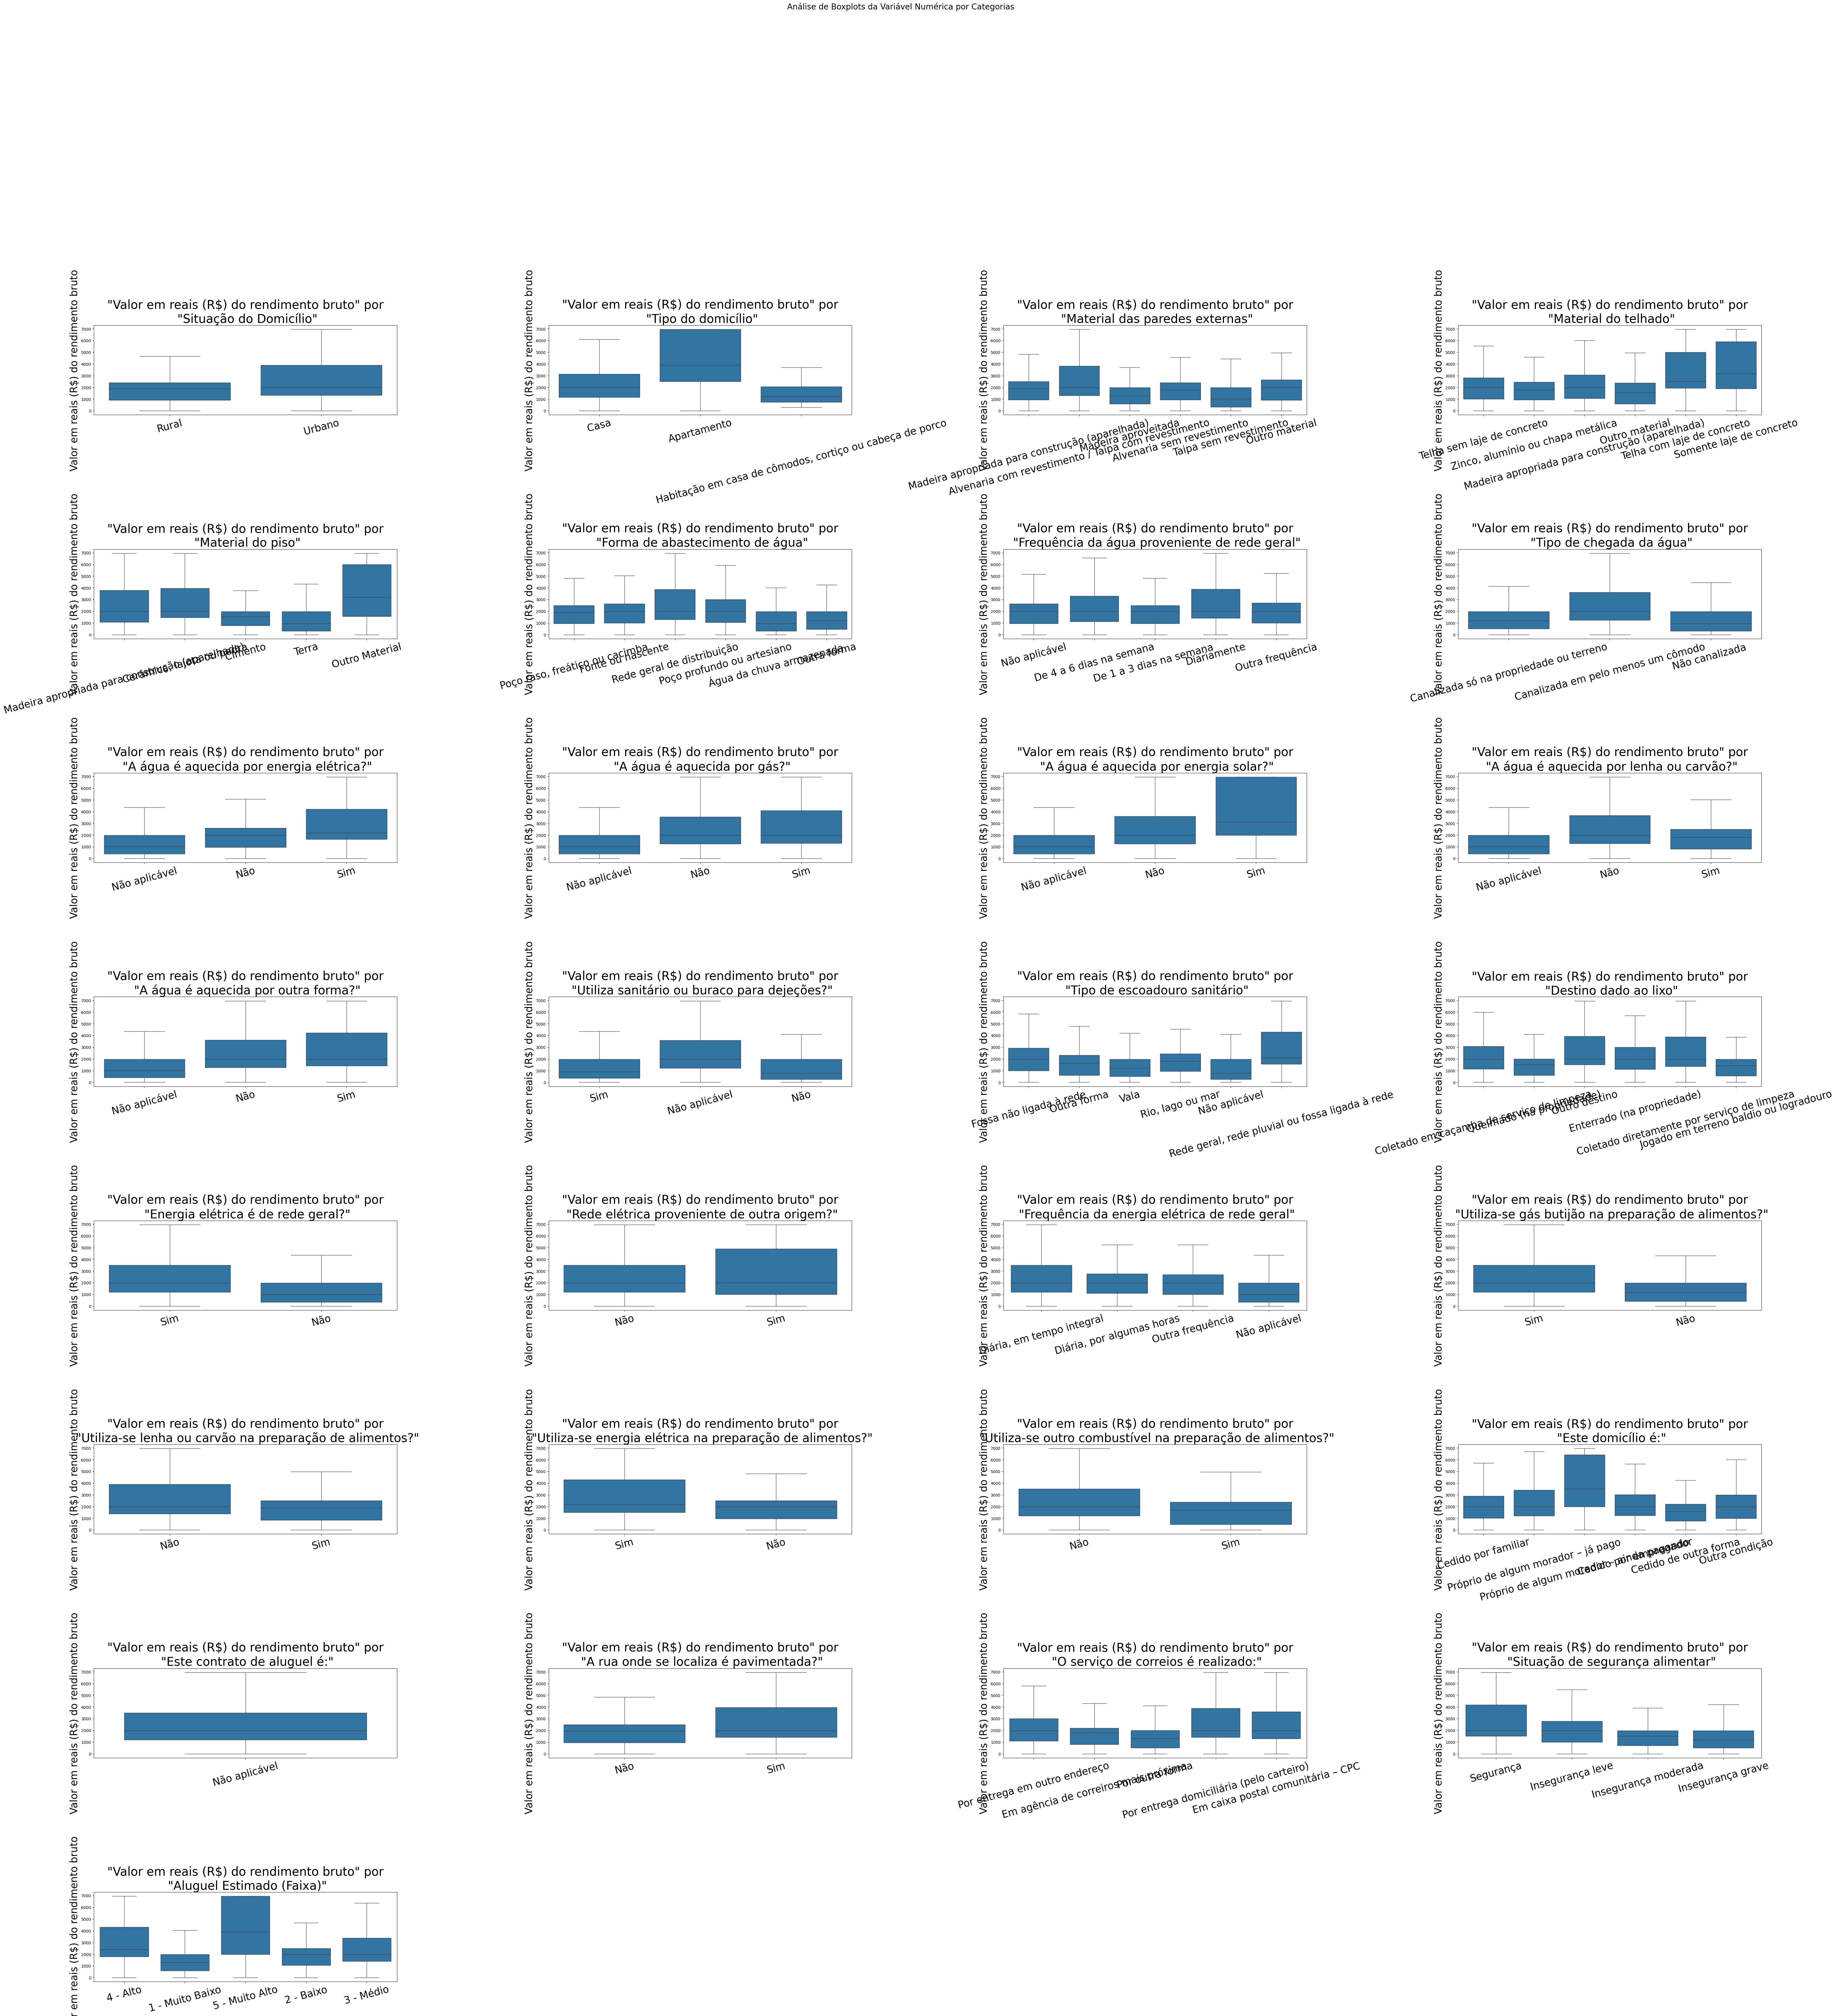

In [28]:
df = df_pof_domicilio

def boxplotsDespesaColetiva(numeric_col):

    try:
        object_cols = df.select_dtypes(include='object').columns[4:]
    except IndexError:
        raise ValueError("DataFrame não contém colunas numéricas ou do tipo 'object' nas quantidades esperadas.")

    # --- Passo 3: Criar a grade de gráficos (subplots) ---

    # Cria a figura e os eixos (axes) com o tamanho calculado
    # O figsize é ajustado dinamicamente para a figura não ficar apertada
    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(75, 75))

    # O 'axes.flatten()' transforma a matriz de eixos 2D em um array 1D para facilitar a iteração
    axes = axes.flatten()

    # --- Passo 4: Loop para criar e plotar cada boxplot ---

    for i, col_cat in enumerate(object_cols):
        ax = axes[i] # Seleciona o eixo atual para desenhar o gráfico
        
        # Cria o boxplot no eixo selecionado
        sns.boxplot(
            x=col_cat,       # Eixo X: as categorias da coluna object atual
            y=numeric_col,   # Eixo Y: a variável numérica
            data=df,         # O DataFrame com os dados
            ax=ax,
            showfliers=False            # O eixo específico onde o gráfico será desenhado
        )
        
        # Personaliza o subplot
        ax.set_title(f'"{numeric_col}" por\n "{col_cat}"', fontsize=30)
        ax.set_xlabel('', fontsize=35) # Remove o label do eixo x para um visual mais limpo
        ax.set_ylabel(f'{numeric_col}', fontsize=25)
        ax.tick_params(axis='x', rotation=15, labelsize=25) # Rotaciona os labels do eixo x se forem longos


    # --- Passo 5: Ajustes Finais ---

    # Oculta os eixos que não foram utilizados (caso o número de plots seja ímpar)
    for i in range(len(object_cols), len(axes)):
        axes[i].set_visible(False)

    # Adiciona um título geral à figura
    fig.suptitle('Análise de Boxplots da Variável Numérica por Categorias', fontsize=20, y=1.03)

    # Ajusta o layout para evitar sobreposição de títulos e labels
    #plt.tight_layout(rect=[0, 0, 1, 0.98]) # rect ajusta o espaço para o suptitle
    plt.subplots_adjust(hspace=1.5, wspace=0.5)

    plt.savefig(f"Gráficos\Boxplots ({numeric_col}).png", dpi=300)

    # Mostra a figura final
    plt.show()

boxplotsDespesaColetiva('Valor em reais (R$) do rendimento bruto')

### Matriz de Covariância

<>:17: SyntaxWarning: invalid escape sequence '\M'
<>:17: SyntaxWarning: invalid escape sequence '\M'
C:\Users\user\AppData\Local\Temp\ipykernel_10336\1630704537.py:17: SyntaxWarning: invalid escape sequence '\M'
  plt.savefig("Gráficos\Mapa de Calor da Covariância.png")


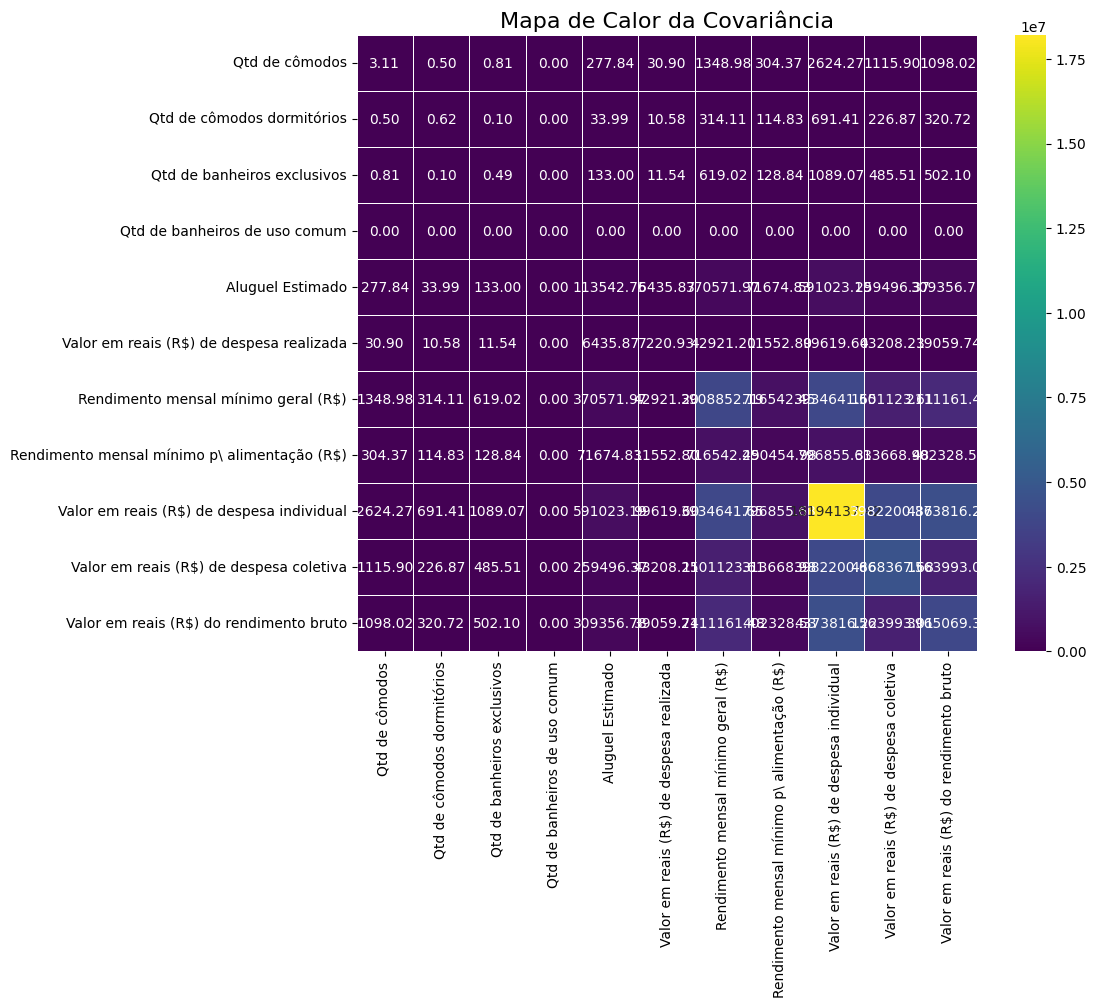

In [29]:
# Calcular a matriz de covariância
cov_matrix = df_pof_domicilio_numeric.cov()

# Configurar a figura do Matplotlib
plt.figure(figsize=(10, 8))

# Gerar o mapa de calor
sns.heatmap(
    cov_matrix, 
    annot=True,      # Mostra os valores de covariância
    fmt='.2f',       # Formata os números (ajuste conforme a escala dos seus dados)
    cmap='viridis',  # Esquema de cores (sequencial é bom para covariância)
    linewidths=.5,
)

plt.title('Mapa de Calor da Covariância', fontsize=16)
plt.savefig("Gráficos\Mapa de Calor da Covariância.png")
plt.show()

## Testes

In [9]:
def analisar_correlacao_com_target(df, coluna_target, alpha=0.05):
    """
    Executa o teste de correlação de Pearson de várias colunas numéricas em
    relação a uma única coluna-alvo (target).

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        coluna_target (str): O nome da coluna alvo para a análise.
        alpha (float, optional): O nível de significância para o teste de hipótese. 
                                 O padrão é 0.05.

    Returns:
        pd.DataFrame: Um DataFrame com os resultados, ordenado pela força da correlação,
                      contendo as colunas: 'Variável', 'Coeficiente (r)', 'P-Valor' e 'Decisao'.
                      Retorna None se a coluna-alvo não existir ou não for numérica.
    """
    # 1. Validar se a coluna-alvo existe no DataFrame
    if coluna_target not in df.columns:
        print(f"Erro: A coluna-alvo '{coluna_target}' não foi encontrada no DataFrame.")
        return None
        
    # 2. Selecionar colunas numéricas, excluindo a própria coluna-alvo da lista de features
    colunas_features = df.select_dtypes(include='number').columns.tolist()
    if coluna_target not in colunas_features:
        print(f"Erro: A coluna-alvo '{coluna_target}' não é do tipo numérico.")
        return None
    
    colunas_features.remove(coluna_target)
    
    # 3. Lista para armazenar os resultados
    resultados = []
    
    # 4. Iterar sobre cada coluna feature e comparar com a coluna-alvo
    for feature in colunas_features:

        # Executar o teste de Pearson
        r, p_valor = pearsonr(df[feature], df[coluna_target])
        
        # 5. Tomar a decisão com base no p-valor
        if p_valor < alpha:
            decisao = f"Rejeitar H₀ (p < {alpha})"
        else:
            decisao = f"Não Rejeitar H₀ (p >= {alpha})"
            
        # Adicionar o resultado à lista
        resultados.append({
            'Variável': feature,
            'Coeficiente (r)': r,
            'P-Valor': p_valor,
            f'Decisão (vs {coluna_target})': decisao
        })
        
    # 6. Criar o DataFrame final e ordenar pela força da correlação (valor absoluto de r)
    if not resultados:
        print("Não foram encontradas outras colunas numéricas para comparar com o alvo.")
        return None

    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.reindex(df_resultados['Coeficiente (r)'].abs().sort_values(ascending=False).index)
    
    return df_resultados.reset_index(drop=True)

# Fonte: Jacob Cohen, "Statistical Power Analysis for the Behavioral Sciences" (1988).
def classificar_r_quadrado_cohen(r_quadrado):
  """
  Classifica a magnitude de um valor de R² com base nas diretrizes
  adaptadas de Jacob Cohen (1988).

  Estas faixas são principalmente um ponto de partida para as ciências
  comportamentais e devem ser usadas com cautela.

  Args:
    r_quadrado (float): O valor do coeficiente de determinação (deve ser entre 0 e 1).

  Returns:
    str: A classificação da magnitude do efeito ('desprezível', 'pequeno',
         'médio' ou 'grande').
  """
  if not 0 <= r_quadrado <= 1:
    return "Valor de R² inválido. Deve estar entre 0 e 1."

  if r_quadrado >= 0.25:
    return "Efeito Grande"
  elif r_quadrado >= 0.09:
    return "Efeito Médio"
  elif r_quadrado >= 0.01:
    return "Efeito Pequeno"
  else:
    return "Efeito Desprezível"

df_corr = analisar_correlacao_com_target(df_pof_domicilio_numeric, 'Aluguel Estimado', alpha=0.05)
df_corr['classificacao'] = df_corr['Coeficiente (r)'].apply(classificar_r_quadrado_cohen)
df_corr

Variável  Coeficiente (r)  P-Valor  \
0                   Qtd de banheiros exclusivos             0.56     0.00   
1           Rendimento mensal mínimo geral (R$)             0.56     0.00   
2                                Qtd de cômodos             0.47     0.00   
3       Valor em reais (R$) do rendimento bruto             0.46     0.00   
4     Valor em reais (R$) de despesa individual             0.41     0.00   
5  Rendimento mensal mínimo p\ alimentação (R$)             0.39     0.00   
6       Valor em reais (R$) de despesa coletiva             0.36     0.00   
7      Valor em reais (R$) de despesa realizada             0.23     0.00   
8                    Qtd de cômodos dormitórios             0.13     0.00   
9                 Qtd de banheiros de uso comum              NaN      NaN   

  Decisão (vs Aluguel Estimado)                                  classificacao  
0        Rejeitar H₀ (p < 0.05)                                  Efeito Grande  
1        Rejeitar H₀ (p < 0.05)                                  Efeito Grande  
2        Rejeitar H₀ (p < 0.05)                                  Efeito Grande  
3        Rejeitar H₀ (p < 0.05)                                  Efeito Grande  
4        Rejeitar H₀ (p < 0.05)                                  Efeito Grande  
5        Rejeitar H₀ (p < 0.05)                                  Efeito Grande  
6        Rejeitar H₀ (p < 0.05)                                  Efeito Grande  
7        Rejeitar H₀ (p < 0.05)                                   Efeito Médio  
8        Rejeitar H₀ (p < 0.05)                                   Efeito Médio  
9   Não Rejeitar H₀ (p >= 0.05)  Valor de R² inválido. Deve estar entre 0 e 1.

In [ ]:
# Função para calcular ANOVA no DIC (CORRIGIDA)
def anova_dic(data, tratamento_col, valor_col):
    
    # 1. Soma Total dos Quadrados (SST) - Sem alterações
    mean_total = data[valor_col].mean()
    sst = ((data[valor_col] - mean_total) ** 2).sum()

    # 2. Soma dos Quadrados do Tratamento (SSTr) - Corrigido para dados desbalanceados
    group_means = data.groupby(tratamento_col)[valor_col].mean()
    group_counts = data.groupby(tratamento_col)[valor_col].count()
    sstr = (group_counts * (group_means - mean_total) ** 2).sum()

    # 3. Soma dos Quadrados do Erro (SSE) - Sem alterações
    sse = sst - sstr

    # 4. Graus de Liberdade - Sem alterações
    n_total = len(data)
    n_tratamentos = len(group_means)
    
    df_total = n_total - 1
    df_tratamento = n_tratamentos - 1
    df_residual = df_total - df_tratamento

    # Evita divisão por zero se não houver graus de liberdade residuais
    if df_residual == 0:
        return {
            "Variável": tratamento_col, "SST": sst, "SSTr": sstr, "SSE": sse,
            "DF Tratamento": df_tratamento, "DF Residual": df_residual,
            "MS Tratamento": None, "MS Residual": None,
            "F_value": None, "p_value": None
        }

    # 5. Média dos Quadrados - Divisor corrigido
    ms_tratamento = sstr / df_tratamento
    ms_residual = sse / df_residual

    # 6. Estatística F - Sem alterações (mas agora usa MS correto)
    f_value = ms_tratamento / ms_residual

    # 7. Valor p - Sem alterações
    p_value = 1 - f.cdf(f_value, df_tratamento, df_residual)

    # Retorna o dicionário completo com os resultados
    return {
        "Variável": tratamento_col,
        "SST": sst, "SSTr": sstr, "SSE": sse,
        "DF Tratamento": df_tratamento, "DF Residual": df_residual,
        "MS Tratamento": ms_tratamento, "MS Residual": ms_residual,
        "F_value": f_value, "p_value": p_value
    }

# Loop para executar a análise (CORRIGIDO E SIMPLIFICADO)
anova_results = []

for col in df_pof_domicilio_obj.columns:
    # Chama a função e anexa o dicionário retornado diretamente à lista
    # Não há necessidade de desempacotar e recriar o dicionário
    results_dict = anova_dic(df_pof_domicilio, col, 'Aluguel Estimado')
    anova_results.append(results_dict)

# Cria o DataFrame final com os resultados
pd.DataFrame(anova_results)

In [11]:
def analisar_chi2_com_target(df, coluna_target, alpha=0.05):
    """
    Realiza o Teste Qui-Quadrado de independência entre cada coluna categórica de um 
    DataFrame e uma coluna-alvo (também categórica).

    Args:
        df (pd.DataFrame): O DataFrame com os dados.
        coluna_target (str): O nome da coluna-alvo para a análise.
        alpha (float, optional): O nível de significância. Padrão é 0.05.

    Returns:
        pd.DataFrame: Um DataFrame com os resultados do teste para cada variável.
    """
    # --- Validação dos Dados de Entrada ---
    if coluna_target not in df.columns:
        print(f"Erro: A coluna-alvo '{coluna_target}' não foi encontrada.")
        return None

    # Verifica se a coluna alvo é categórica (object, category, ou bool)
    if df[coluna_target].dtype.name not in ['object', 'category', 'bool']:
        print(f"Erro: A coluna-alvo '{coluna_target}' deve ser categórica.")
        return None

    # Seleciona apenas as colunas categóricas, excluindo a própria coluna-alvo
    colunas_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    if coluna_target in colunas_features:
        colunas_features.remove(coluna_target)
    
    if not colunas_features:
        print("Nenhuma outra coluna categórica encontrada para análise.")
        return None

    # --- Execução do Teste ---
    resultados = []
    
    for feature in colunas_features:
        try:
            # 1. Criar a Tabela de Contingência
            tabela_contingencia = pd.crosstab(df[feature], df[coluna_target])
            
            # 2. Executar o teste
            chi2, p, dof, expected = chi2_contingency(tabela_contingencia)

            v = association(tabela_contingencia, method="cramer")

            classificacao = classify_cramers_v(v)

            # 3. Tomar a decisão
            if p < alpha:
                decisao = f"Rejeitar H₀ (p < {alpha})"
            else:
                decisao = f"Não Rejeitar H₀ (p >= {alpha})"
            
            resultados.append({
                'Variável': feature,
                'Estatística Chi-Squared (χ²)': chi2,
                'P-Valor': p,
                'Decisão (H₀: São Independentes)': decisao,
                'V de Cramer': v,
                'Classificação': classificacao
            })
        except ValueError:
            # Captura erros se a tabela de contingência for inválida para o teste
            resultados.append({
                'Variável': feature,
                'Estatística Chi-Squared (χ²)': 'Erro',
                'P-Valor': 'Erro',
                'Decisão (H₀: São Independentes)': 'Não foi possível calcular',
                'V de Cramer': v
            })
            
    df_resultados = pd.DataFrame(resultados)
    # Ordena pela estatística Chi-Squared para ver as associações mais fortes primeiro
    df_resultados = df_resultados.sort_values(by='Estatística Chi-Squared (χ²)', ascending=False)
    
    return df_resultados.reset_index(drop=True)

# Fonte: Jacob Cohen, "Statistical Power Analysis for the Behavioral Sciences" (1988).
def classify_cramers_v(v_value):
                    if v_value < 0.10: return "Desprezível ou Muito Fraca"
                    if v_value < 0.20: return "Fraca"
                    if v_value < 0.40: return "Moderada"
                    if v_value < 0.60: return "Forte"
                    return "Muito Forte"
            
df_chi_square = analisar_chi2_com_target(df_pof_domicilio_obj.drop(['uf'], axis=1), 'Aluguel Estimado (Faixa)', alpha=0.000001)
df_chi_square.sort_values(by=['V de Cramer'], ascending=False).sort_index()

Variável  \
0                                 Material do telhado   
1                                    Material do piso   
2             A água é aquecida por energia elétrica?   
3                        Tipo de escoadouro sanitário   
4                  O serviço de correios é realizado:   
5               A rua onde se localiza é pavimentada?   
6                                Destino dado ao lixo   
7                               Situação do Domicílio   
8                A água é aquecida por energia solar?   
9              A água é aquecida por lenha ou carvão?   
10                    Situação de segurança alimentar   
11       Frequência da água proveniente de rede geral   
12  Utiliza-se lenha ou carvão na preparação de al...   
13                         A água é aquecida por gás?   
14                     Forma de abastecimento de água   
15                            Tipo de chegada da água   
16                 A água é aquecida por outra forma?   
17                                  Tipo do domicílio   
18                      Material das paredes externas   
19         Utiliza sanitário ou buraco para dejeções?   
20  Utiliza-se energia elétrica na preparação de a...   
21                                  Este domicílio é:   
22  Utiliza-se gás butijão na preparação de alimen...   
23       Frequência da energia elétrica de rede geral   
24                  Energia elétrica é de rede geral?   
25         Rede elétrica proveniente de outra origem?   
26  Utiliza-se outro combustível na preparação de ...   
27                        Este contrato de aluguel é:   

    Estatística Chi-Squared (χ²)  P-Valor Decisão (H₀: São Independentes)  \
0                       10001.06     0.00         Rejeitar H₀ (p < 1e-06)   
1                        9675.20     0.00         Rejeitar H₀ (p < 1e-06)   
2                        9592.37     0.00         Rejeitar H₀ (p < 1e-06)   
3                        8773.58     0.00         Rejeitar H₀ (p < 1e-06)   
4                        7504.04     0.00         Rejeitar H₀ (p < 1e-06)   
5                        6381.90     0.00         Rejeitar H₀ (p < 1e-06)   
6                        6043.45     0.00         Rejeitar H₀ (p < 1e-06)   
7                        5342.64     0.00         Rejeitar H₀ (p < 1e-06)   
8                        4440.91     0.00         Rejeitar H₀ (p < 1e-06)   
9                        4206.61     0.00         Rejeitar H₀ (p < 1e-06)   
10                       4193.85     0.00         Rejeitar H₀ (p < 1e-06)   
11                       4162.40     0.00         Rejeitar H₀ (p < 1e-06)   
12                       4075.24     0.00         Rejeitar H₀ (p < 1e-06)   
13                       4054.39     0.00         Rejeitar H₀ (p < 1e-06)   
14                       4025.00     0.00         Rejeitar H₀ (p < 1e-06)   
15                       4015.42     0.00         Rejeitar H₀ (p < 1e-06)   
16                       3849.77     0.00         Rejeitar H₀ (p < 1e-06)   
17                       3736.16     0.00         Rejeitar H₀ (p < 1e-06)   
18                       3208.49     0.00         Rejeitar H₀ (p < 1e-06)   
19                       3062.37     0.00         Rejeitar H₀ (p < 1e-06)   
20                       3051.32     0.00         Rejeitar H₀ (p < 1e-06)   
21                       1412.37     0.00         Rejeitar H₀ (p < 1e-06)   
22                        806.84     0.00         Rejeitar H₀ (p < 1e-06)   
23                        563.79     0.00         Rejeitar H₀ (p < 1e-06)   
24                        531.27     0.00         Rejeitar H₀ (p < 1e-06)   
25                        154.38     0.00         Rejeitar H₀ (p < 1e-06)   
26                         33.36     0.00    Não Rejeitar H₀ (p >= 1e-06)   
27                          0.00     1.00    Não Rejeitar H₀ (p >= 1e-06)   

    V de Cramer               Classificação  
0          0.23                    Moderada  
1          0.23                    Moderada  
2          0.32    

In [12]:
# Função para calcular ANOVA no DIC (CORRIGIDA)
def anova_dic(data, tratamento_col, valor_col):
    
    # 1. Soma Total dos Quadrados (SST) - Sem alterações
    mean_total = data[valor_col].mean()
    sst = ((data[valor_col] - mean_total) ** 2).sum()

    # 2. Soma dos Quadrados do Tratamento (SSTr) - Corrigido para dados desbalanceados
    group_means = data.groupby(tratamento_col)[valor_col].mean()
    group_counts = data.groupby(tratamento_col)[valor_col].count()
    sstr = (group_counts * (group_means - mean_total) ** 2).sum()

    # 3. Soma dos Quadrados do Erro (SSE) - Sem alterações
    sse = sst - sstr

    # 4. Graus de Liberdade - Sem alterações
    n_total = len(data)
    n_tratamentos = len(group_means)
    
    df_total = n_total - 1
    df_tratamento = n_tratamentos - 1
    df_residual = df_total - df_tratamento

    # Evita divisão por zero se não houver graus de liberdade residuais
    if df_residual == 0:
        return {
            "Variável": valor_col, "SST": sst, "SSTr": sstr, "SSE": sse,
            "DF Tratamento": df_tratamento, "DF Residual": df_residual,
            "MS Tratamento": None, "MS Residual": None,
            "F_value": None, "p_value": None
        }

    # 5. Média dos Quadrados - Divisor corrigido
    ms_tratamento = sstr / df_tratamento
    ms_residual = sse / df_residual

    # 6. Estatística F - Sem alterações (mas agora usa MS correto)
    f_value = ms_tratamento / ms_residual

    # 7. Valor p - Sem alterações
    p_value = 1 - f.cdf(f_value, df_tratamento, df_residual)

    # Retorna o dicionário completo com os resultados
    return {
        "Variável": valor_col,
        "SST": sst, "SSTr": sstr, "SSE": sse,
        "DF Tratamento": df_tratamento, "DF Residual": df_residual,
        "MS Tratamento": ms_tratamento, "MS Residual": ms_residual,
        "F_value": f_value, "p_value": p_value
    }

# Loop para executar a análise (CORRIGIDO E SIMPLIFICADO)
anova_results = []

for col in df_pof_domicilio_numeric.columns:
    # Chama a função e anexa o dicionário retornado diretamente à lista
    # Não há necessidade de desempacotar e recriar o dicionário
    results_dict = anova_dic(df_pof_domicilio, 'Aluguel Estimado (Faixa)', col)
    anova_results.append(results_dict)

# Cria o DataFrame final com os resultados
pd.DataFrame(anova_results)

Variável             SST  \
0                                 Qtd de cômodos       143855.67   
1                     Qtd de cômodos dormitórios        28916.20   
2                    Qtd de banheiros exclusivos        22651.26   
3                  Qtd de banheiros de uso comum            0.00   
4                               Aluguel Estimado   5258618946.53   
5       Valor em reais (R$) de despesa realizada    333980492.08   
6            Rendimento mensal mínimo geral (R$) 181034580111.52   
7   Rendimento mensal mínimo p\ alimentação (R$)  13452132114.74   
8      Valor em reais (R$) de despesa individual 842643280646.88   
9        Valor em reais (R$) de despesa coletiva 216210780727.49   
10       Valor em reais (R$) do rendimento bruto 184868651955.94   

              SSTr             SSE  DF Tratamento  DF Residual  MS Tratamento  \
0         28774.97       115080.69              4        46310        7193.74   
1           447.43        28468.76              4        46310         111.86   
2          6384.09        16267.17              4        46310        1596.02   
3             0.00            0.00              4        46310           0.00   
4    4922440284.69    336178661.84              4        46310  1230610071.17   
5      15113940.88    318866551.20              4        46310     3778485.22   
6   51474610974.00 129559969137.52              4        46310 12868652743.50   
7    1879579551.10  11572552563.64              4        46310   469894887.77   
8  129913767101.67 712729513545.21              4        46310 32478441775.42   
9   24450096120.24 191760684607.25              4        46310  6112524030.06   
10  37608562703.72 147260089252.22              4        46310  9402140675.93   

    MS Residual   F_value  p_value  
0          2.49   2894.86     0.00  
1          0.61    181.96     0.00  
2          0.35   4543.61     0.00  
3          0.00       NaN      NaN  
4       7259.31 169521.62     0.00  
5       6885.48    548.76     0.00  
6    2797667.22   4599.78     0.00  
7     249893.17   1880.38     0.00  
8   15390401.93   2110.30     0.00  
9    4140805.11   1476.17     0.00  
10   3179876.68   2956.76     0.00